In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import math
from mpl_toolkits.axes_grid1 import ImageGrid
import diverge.output as do

#change to directory of current script



def plotBandStructure(mod,save=False):
    #fig = plt.figure(layout="constrained", figsize=(3,2))
    xvals = do.bandstructure_xvals(mod)
    bands = do.bandstructure_bands(mod)
    ymax = np.max(bands)
    ymin = np.min(bands)
    yrange = ymax - ymin
    ybuffer= yrange*0.1
    plt.plot( xvals, bands, c='navy' )
    
    xticks = do.bandstructure_ticks(mod)
    if len(mod.klabels) == len(xticks):
        plt.xticks(xticks, mod.klabels)
    else:
        plt.xticks(xticks, [i for i in range(len(xticks))])

    #print(xticks)
    #exit(0)

    plt.hlines(0, xvals[0], xvals[-1], colors='k',  linestyles='-')
    
    #N_segment = 300
    for i in range(len(xticks)-1):
        plt.vlines(xticks[i], ymin-ybuffer,ymax+ybuffer, colors='k', linestyles='dashed')
        #plt.axvline(steps[i*N_segment], color="black", lw=0.5, linestyle="--")
        #xticks.append(steps[i*N_segment])
        #xticklabels.append(i)
    plt.xlim( xvals[0], xvals[-1] )
    plt.ylim(ymin-ybuffer,ymax+ybuffer)

    plt.xlabel( r'$\mathbf{k}$' )
    plt.ylabel( r'$\epsilon_b({\bf k})$' )


    
    if save==True: 
        plt.savefig('bands.pdf')

    plt.show()

def suscepPlot(mod,out,channel="P",title=""):
    #Channel = "P" "C" or "D"
    no = mod.n_orb
    ns = mod.n_spin
    kmesh = mod.bandstructure[:,-3:]

    ibz_edges = kmesh[::300].T
    ucx, ucy, ucz = mod.lattice.T
    kxv, kyv, kzv = mod.kmesh.T
    kvec = mod.kmesh
    nkx = mod.nk[0]
    nky = mod.nk[1]
    nkz = mod.nk[2]

    # generate real space mesh
    Rx = np.arange(0,nkx,1)
    Ry = np.arange(0,nky,1)
    Rx[Rx>nkx/2-1+1e-5] -= nkx
    Ry[Ry>nky/2-1+1e-5] -= nky

    Rx, Ry = np.meshgrid(Rx,Ry)
    R1 = np.ndarray.flatten(Rx)
    R2 = np.ndarray.flatten(Ry)

    uc1 = np.array([ucx[0],ucy[0],ucz[0]])
    uc2 = np.array([ucx[1],ucy[1],ucz[1]])
    FFT_realspace_vectors = uc1[:,None]*R1[None,:] + uc2[:,None]*R2[None,:]
    

    exponential = np.exp(1j*np.einsum('ir,ki->rk',FFT_realspace_vectors,kvec)) #this is for the Fourier transform somehow?

    if channel == "P":
        susz = out.Psusc
    elif channel == "C":
        susz = out.Csusc
    elif channel == "D":
        susz = out.Dsusc
    else:
        print("Invalid channel")
        return
    
    susz = np.einsum('abcdabcdk->bdk',susz)
    func_R = np.einsum('...k,rk->...r',susz,exponential)
    #generate target mesh
    N_segment = 300
    ibz_path = np.zeros((N_segment*(ibz_edges.shape[1]-1),3))
    steps = np.linspace(0,1,N_segment)

    for edge in range(1,ibz_edges.shape[1]):
        ibz_path[(edge-1)*N_segment:edge*N_segment,:] = (1.-steps[:,None])*ibz_edges[:,edge-1][None,:] + steps[:,None] * ibz_edges[:,edge][None,:]


    steps = np.linspace(0,1,N_segment*(ibz_edges.shape[1]-1))
    exponential = np.exp(-1j*np.einsum('ir,ki->rk',FFT_realspace_vectors,ibz_path))

    ibz_susz = np.einsum('...r,rk->k...',func_R,exponential)/len(kxv)

    k_idx = []
    where_on_path = []
    for i in range(len(kxv)):
        diff_to_all = np.linalg.norm(kvec[i,:][:,None]-ibz_path.transpose(), axis = 0)
        if(np.min(diff_to_all) < 12./N_segment):
            k_idx.append(i)
            where_on_path.append(np.argmin(diff_to_all))

    where_on_path = np.asarray(where_on_path)
    k_idx = np.asarray(k_idx)

    perm = where_on_path.argsort()
    where_on_path = where_on_path[perm]
    k_idx = k_idx[perm]

    lines_maker1 =[]
    fig = plt.figure(figsize=(4.2,3.15))
    ax = fig.add_subplot(111)
    orbc = ["1z2"]
    colors= ["purple"]
    for i in range(no):
        line2 = ax.plot(steps, np.abs(np.real(ibz_susz[:,i,i]))) #lines_maker1.append(line2[0])
        ax.plot(steps[where_on_path],np.abs(np.real(susz[i,i, k_idx])),color =
                    "black",marker=".",linestyle="None")

    #ax.scatter(steps,dx2y2,c="black",marker="o")

  
    #lines_maker1.append(line2[0])
    #ax.plot(steps[where_on_path],np.abs(np.real(susz[i,i, k_idx])),color =
    #        "black",marker=".",linestyle="None")
            

    #for i in range(no):
    #    for j in range(0,i):
    #        line2 = ax.plot(steps, np.abs(np.real(ibz_susz[:,i,j])),linestyle = "--", label = orbc[i]+";"+orbc[j])
    #        lines_maker1.append(line2[0])

    if channel == "P":
        plt.title("SC susceptibility "+title)
    elif channel == "C":
        plt.title("SDW susceptibility "+title)
    elif channel == "D":
        plt.title("CDW susceptibility "+title)
    else:
        plt.title("suscep? "+title)
    ax.set_ylabel("Chi")
    
    xticks = []
    xticklabels = []
    for i in range(ibz_edges.shape[1]-1):
        ax.axvline(steps[i*N_segment], color="black", lw=0.5, linestyle="--")
        xticks.append(steps[i*N_segment])
        xticklabels.append(i)
    #final line
    ax.axvline(steps[-1], color="black", lw=0.5, linestyle="--")
    xticks.append(steps[-1])
    xticklabels.append(ibz_edges.shape[1])


    ax.set_xticks(xticks)
    if len(mod.klabels) == len(xticks):
        ax.set_xticklabels(mod.klabels)
    else:
        ax.set_xticklabels(xticklabels)
    
    ax.set_xlabel(r"$\mathbf{q}$")

def save_SCgap(data, mod, channel, plot_vector, gap_file="gap_file.txt"):
    kmesh= mod.kmesh
    nkp = kmesh.shape[0]
    ofrom = data.mi_to_ofrom
    oto = data.mi_to_oto
    miR = data.mi_to_R
    #print(miR)
    mirr = miR
    uniquemiR = np.unique(miR, axis=0)
    #print(np.sort(uniquemiR))
    # reexpress R vectors is absolute units
    miR = miR[:,0][:,None]*mod.lattice[0,:][None,:] + miR[:,1][:,None]*mod.lattice[1,:][None,:] + miR[:,2][:,None]*mod.lattice[2,:][None,:]
    #print(miR)
    uniquemiR_lat = uniquemiR[:,0][:,None]*mod.lattice[0,:][None,:] + uniquemiR[:,1][:,None]*mod.lattice[1,:][None,:] + uniquemiR[:,2][:,None]*mod.lattice[2,:][None,:]
    ff_ = np.exp(1j*np.einsum("ri,ki->kr",miR,kmesh))
    #print(ff_.shape)
    nsites = data.n_orb
    nbonds = data.n_bonds
    norbff = data.n_orbff
    nspin = data.n_spin
    no = nsites
    ns = nspin
    
    #print("plotvectorshape", plot_vector[:,:,7:16].shape)
    plot_vector = np.copy(plot_vector)
    #plot_vector[:,:,7:16] *= 0
    #plot_vector[:,:,18:] *= 0
    Ukoo = np.zeros((nsites, nspin ,nsites, nspin, nkp), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        val = plot_vector[:,:,idx][:,:,None]*ff_[:,idx][None,None,:]
        Ukoo[o1,:,o2,:,:] += val
    Ukoo = Ukoo.reshape(no*ns,no*ns,nkp)

    
    if channel == "C":
        Ukoo = Ukoo + np.conj(Ukoo.swapaxes(0,1))

    # This gives the evec in ff and orbital space.
    Ukooo = np.zeros((nsites,nsites, len(uniquemiR)), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        aa=0
        for j in range(len(uniquemiR)):
            #print("TEST", np.allclose(mirr[idx], uniquemiR[j]))
            if np.allclose(mirr[idx], uniquemiR[j]):
                aa=j
        val = plot_vector[:,:,idx][:,:,None]
        Ukooo[o1,o2,aa] += val

    normo = plt.Normalize(-np.max(np.abs(Ukooo)),np.max(np.abs(Ukooo)))
    normo = np.ndarray.flatten(Ukooo)[np.argmax(np.abs(np.ndarray.flatten(Ukooo)))]
    Ukooo *= np.conj(normo)/np.abs(normo)

    #print(uniquemiR)
    #print(Ukooo.shape)
    #exit(0)
    #for i in range(int(len(uniquemiR))):
    #    print(np.abs(  Ukooo[:,:,i]))
    #    print(np.angle(Ukooo[:,:, i]))
    #    print("ff",     uniquemiR[i])
    #    print("ff_lat",     uniquemiR_lat[i])

    f = open(gap_file, "w")
    for i in range(int(len(uniquemiR))):
        Rx = uniquemiR[i][0]
        Ry = uniquemiR[i][1]
        Rz = uniquemiR[i][2]
        for o1 in range(len(Ukooo)):
            for o2 in range(len(Ukoo[o1])):
                line =f"{Rx} {Ry} {Rz} {o1} {o2} {np.real(Ukooo[o1,o2,i])} {np.imag(Ukooo[o1,o2,i])}\n"
                f.write(line)
    f.close()

def plot_SCgap(data, mod, channel, plot_vector, eval, real_space=False):
    kmesh= mod.kmesh
    nkp = kmesh.shape[0]
    ofrom = data.mi_to_ofrom
    oto = data.mi_to_oto
    miR = data.mi_to_R
    #print(miR)
    mirr = miR
    uniquemiR = np.unique(miR, axis=0)
    #print(np.sort(uniquemiR))
    # reexpress R vectors is absolute units
    miR = miR[:,0][:,None]*mod.lattice[0,:][None,:] + miR[:,1][:,None]*mod.lattice[1,:][None,:] + miR[:,2][:,None]*mod.lattice[2,:][None,:]
    #print(miR)
    uniquemiR_lat = uniquemiR[:,0][:,None]*mod.lattice[0,:][None,:] + uniquemiR[:,1][:,None]*mod.lattice[1,:][None,:] + uniquemiR[:,2][:,None]*mod.lattice[2,:][None,:]
    ff_ = np.exp(1j*np.einsum("ri,ki->kr",miR,kmesh))
    #print(ff_.shape)
    nsites = data.n_orb
    nbonds = data.n_bonds
    norbff = data.n_orbff
    nspin = data.n_spin
    no = nsites
    ns = nspin
    
    #print("plotvectorshape", plot_vector[:,:,7:16].shape)
    plot_vector = np.copy(plot_vector)
    #plot_vector[:,:,7:16] *= 0
    #plot_vector[:,:,18:] *= 0
    Ukoo = np.zeros((nsites, nspin ,nsites, nspin, nkp), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        val = plot_vector[:,:,idx][:,:,None]*ff_[:,idx][None,None,:]
        Ukoo[o1,:,o2,:,:] += val
    Ukoo = Ukoo.reshape(no*ns,no*ns,nkp)

    
    if channel == "C":
        Ukoo = Ukoo + np.conj(Ukoo.swapaxes(0,1))

    # This gives the evec in ff and orbital space.
    Ukooo = np.zeros((nsites,nsites, len(uniquemiR)), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        aa=0
        for j in range(len(uniquemiR)):
            #print("TEST", np.allclose(mirr[idx], uniquemiR[j]))
            if np.allclose(mirr[idx], uniquemiR[j]):
                aa=j
        val = plot_vector[:,:,idx][:,:,None]
        Ukooo[o1,o2,aa] += val

    normo = plt.Normalize(-np.max(np.abs(Ukooo)),np.max(np.abs(Ukooo)))
    normo = np.ndarray.flatten(Ukooo)[np.argmax(np.abs(np.ndarray.flatten(Ukooo)))]
    Ukooo *= np.conj(normo)/np.abs(normo)

    #print(uniquemiR)
    #print(Ukooo.shape)
    #exit(0)
    #for i in range(int(len(uniquemiR))):
    #    print(np.abs(  Ukooo[:,:,i]))
    #    print(np.angle(Ukooo[:,:, i]))
    #    print("ff",     uniquemiR[i])
    #    print("ff_lat",     uniquemiR_lat[i])


    
    #sub_lat = np.array([[3.012570, 0, 0], [-1.506285, 2.608962, 0], [1.506285, 2.608962,0]]) # Anja model
    #sub_lat = np.array([[np.sqrt(3)/2, 0, 0], [np.sqrt(3)/2- np.sqrt(3)/4, 1/4, 0], [np.sqrt(3)/2+ np.sqrt(3)/4, 1/4,0]]) # Toy kagome
    #sub_lat = np.array([[3.012570, -1.506285, 1.506285], [0, 2.608962, 2.608962], [0, 0,0]])
    sub_lat = mod.positions
    #print("BREAK")
    #print(sub_lat.shape)
    #print(np.swapaxes(Ukooo,0,2).shape)
    #print(uniquemiR_lat.shape)
    if real_space == True:
        full(uniquemiR_lat, sub_lat, np.swapaxes(Ukooo,0,2), save_path="test")

    norm = np.ndarray.flatten(Ukoo)[np.argmax(np.abs(np.ndarray.flatten(Ukoo)))]
    Ukoo *= np.conj(norm)/np.abs(norm)
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.abs(Ukoo[o1,o2,:]),norm = plt.Normalize(0,np.max(np.abs(Ukoo))), s = 10, linewidths=0.1,cmap="plasma")
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')
    #plot title in top center of image grid
    center_idx = math.ceil(no*ns/2)-1
    ax[center_idx].set_title(channel + "  " + str(eval))
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])

    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.angle(Ukoo[o1,o2,:]), vmin=-np.pi, vmax=np.pi, s = 10, linewidths=0.1,cmap="twilight") #norm = plt.Normalize(-1,1)
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')
            
    ax[center_idx].set_title(channel + "  " + str(eval))
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])

    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    # normalize and gauge maximal value to be real
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    norm = np.ndarray.flatten(Ukoo)[np.argmax(np.abs(np.ndarray.flatten(Ukoo)))]
    Ukoo *= np.conj(norm)/np.abs(norm)
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.real(Ukoo[o1,o2,:]),norm = norm, s = 10, linewidths=0.1,cmap="bwr")
            #ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.angle(Ukoo[o1,o2,:]), s = 10*np.abs(Ukoo[o1,o2,:]), linewidths=0.1,cmap="twilight")
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')
            #ax[q].set_title(q)
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])
    plt.show()
    #plt.savefig(filename[:-4]+"real_xy_real.png",bbox_inches='tight',dpi = 600)
    #plt.close("all")


def full(R_list, sublattice, state_to_plot, title=None, save_path=None):
    """
    Plots the absolute value and phase of an eigenstate in the BZ
    """
    c_range = np.array([-np.pi, np.pi])
    cmap = "twilight"
    to_plot = np.angle(state_to_plot)
    dotsize = 90 * np.abs(state_to_plot)
    print("dotsize", dotsize.shape)
    y_label = "Phase"
    for i in range(int(len(R_list))):
        print(dotsize[i,:,:])
        print(to_plot[i,:,:])
        print("ff",     R_list[i])

    real_space(R_list, sublattice, to_plot, dotsize, c_range, cmap,
               y_label, title, save_path)


def real_space(R_list, sublattice, to_plot, dotsize, c_range=None,
               cmap="viridis", y_label=None, title=None, save_path=None):
    """
    Take a function in formfactor space and plots it on the real space mesh
    """
    no = to_plot.shape[-1]
    fig, ax = plt.subplots(1, no)
    ax = np.array(ax).reshape(no) #takes care of case no=1
    if title:
        fig.suptitle(title, fontsize=10, y=1.03, x=0.40)

    if c_range is None:
        c_range = np.array([np.min(np.abs(to_plot)),
                            np.max(np.abs(to_plot))])

    for o0 in range(no):
        # plot reference site
        ax[o0].plot([sublattice[o0, 0]], [sublattice[o0, 1]], "x")
        print(o0)
        print("test", [sublattice[o0, 0]], [sublattice[o0, 1]])
        for o1 in range(no):
            # plot real space distribution
            ax[o0].scatter(R_list[:, 0] + sublattice[o1, 0],
                           R_list[:, 1] + sublattice[o1, 1],
                           dotsize[:, o0, o1], c=to_plot[:, o0, o1],
                           vmin=-np.pi, vmax=np.pi, cmap=cmap)

            ax[o0].set_aspect("equal")
            plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.5)
            ax[o0].set_xticks([])
            ax[o0].set_yticks([])

        ax[-1].set_ylabel("$k_y$")
        ax[-1].set_xlabel("$k_x$")

        norm = plt.Normalize(c_range[0], c_range[1])
        sm = ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.80, 0.2, 0.03, 0.6])

        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.ax.set_ylabel(y_label)

        if np.allclose(c_range, np.array([-np.pi, np.pi])):
            cbar.set_ticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
            cbar.set_ticklabels(["$-\pi$", "$-\pi/2$", "$0$",
                                 "$\pi/2$", "$\pi$"])

    if save_path:
        fig.savefig(save_path + ".pdf")
    else:
        plt.show()



    return 0






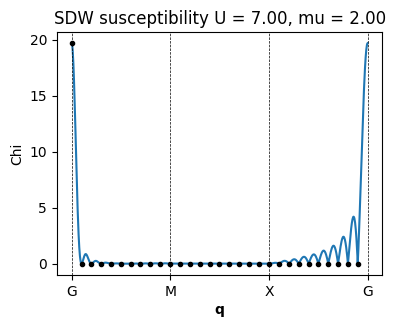

In [22]:
# stripe at mu = 2.0eV

import numpy as np
import matplotlib.pyplot as plt


mu = "2.00"
Uvals = np.arange(7, 8, 1)
Uvals_str = [f"{value:.2f}" for value in Uvals]



for i, u in enumerate(Uvals_str):
    
    nk = 20
    nkf = 5

    ff = "4.00"
    mod = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_mod.dvg")
    mod.klabels = ["G", "M", "X", "G"]

    out = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_out.dvg")

   
    suscepPlot(mod, out, channel="C", title=f"U = {u}, mu = {mu}")


plt.show()

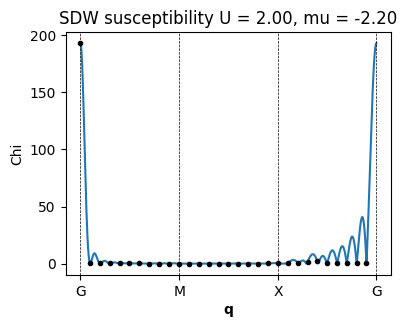

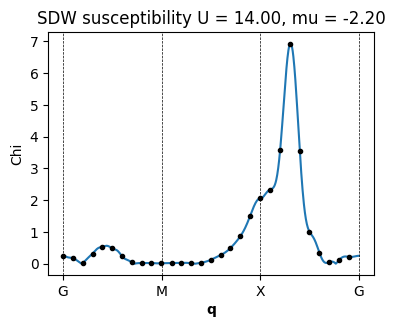

In [23]:
# stripe at mu = -2.2eV

import numpy as np
import matplotlib.pyplot as plt


mu = "-2.20"
Uvals = np.array([2,14])
Uvals_str = [f"{value:.2f}" for value in Uvals]



for i, u in enumerate(Uvals_str):
    
    nk = 20
    nkf = 5

    ff = "4.00"
    mod = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_mod.dvg")
    mod.klabels = ["G", "M", "X", "G"]

    out = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_out.dvg")

   
    suscepPlot(mod, out, channel="C", title=f"U = {u}, mu = {mu}")


plt.show()

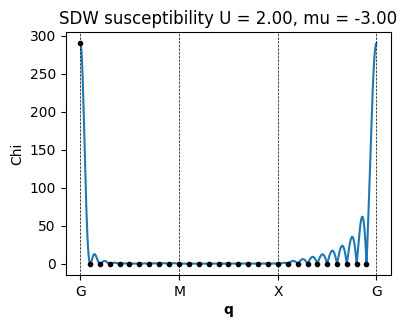

In [24]:
# stripe at mu = -3.0eV

import numpy as np
import matplotlib.pyplot as plt


mu = "-3.00"
Uvals = np.arange(2, 3, 1)
Uvals_str = [f"{value:.2f}" for value in Uvals]



for i, u in enumerate(Uvals_str):
    
    nk = 20
    nkf = 5

    ff = "4.00"
    mod = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_mod.dvg")
    mod.klabels = ["G", "M", "X", "G"]

    out = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_out.dvg")

   
    suscepPlot(mod, out, channel="C", title=f"U = {u}, mu = {mu}")


plt.show()

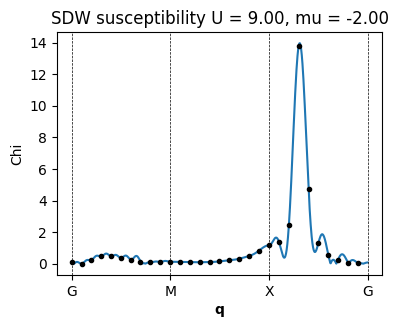

In [25]:
# SC vertical cut

import numpy as np
import matplotlib.pyplot as plt


mu = "-2.00"
Uvals = np.arange(9, 10, 1)
Uvals_str = [f"{value:.2f}" for value in Uvals]



for i, u in enumerate(Uvals_str):
    
    nk = 20
    nkf = 5

    ff = "4.00"
    mod = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_mod.dvg")
    mod.klabels = ["G", "M", "X", "G"]

    out = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_out.dvg")

   
    suscepPlot(mod, out, channel="C", title=f"U = {u}, mu = {mu}")


plt.show()



# Plot SC gap

In [26]:
def save_SCgap(data, mod, channel, plot_vector, gap_file="gap_file.txt"):
    kmesh= mod.kmesh
    nkp = kmesh.shape[0]
    ofrom = data.mi_to_ofrom
    oto = data.mi_to_oto
    miR = data.mi_to_R
    #print(miR)
    mirr = miR
    uniquemiR = np.unique(miR, axis=0)
    #print(np.sort(uniquemiR))
    # reexpress R vectors is absolute units
    miR = miR[:,0][:,None]*mod.lattice[0,:][None,:] + miR[:,1][:,None]*mod.lattice[1,:][None,:] + miR[:,2][:,None]*mod.lattice[2,:][None,:]
    #print(miR)
    uniquemiR_lat = uniquemiR[:,0][:,None]*mod.lattice[0,:][None,:] + uniquemiR[:,1][:,None]*mod.lattice[1,:][None,:] + uniquemiR[:,2][:,None]*mod.lattice[2,:][None,:]
    ff_ = np.exp(1j*np.einsum("ri,ki->kr",miR,kmesh))
    #print(ff_.shape)
    nsites = data.n_orb
    nbonds = data.n_bonds
    norbff = data.n_orbff
    nspin = data.n_spin
    no = nsites
    ns = nspin
    
    #print("plotvectorshape", plot_vector[:,:,7:16].shape)
    plot_vector = np.copy(plot_vector)
    #plot_vector[:,:,7:16] *= 0
    #plot_vector[:,:,18:] *= 0
    Ukoo = np.zeros((nsites, nspin ,nsites, nspin, nkp), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        val = plot_vector[:,:,idx][:,:,None]*ff_[:,idx][None,None,:]
        Ukoo[o1,:,o2,:,:] += val
    Ukoo = Ukoo.reshape(no*ns,no*ns,nkp)

    
    if channel == "C":
        Ukoo = Ukoo + np.conj(Ukoo.swapaxes(0,1))

    # This gives the evec in ff and orbital space.
    Ukooo = np.zeros((nsites,nsites, len(uniquemiR)), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        aa=0
        for j in range(len(uniquemiR)):
            #print("TEST", np.allclose(mirr[idx], uniquemiR[j]))
            if np.allclose(mirr[idx], uniquemiR[j]):
                aa=j
        val = plot_vector[:,:,idx][:,:,None]
        Ukooo[o1,o2,aa] += val

    normo = plt.Normalize(-np.max(np.abs(Ukooo)),np.max(np.abs(Ukooo)))
    normo = np.ndarray.flatten(Ukooo)[np.argmax(np.abs(np.ndarray.flatten(Ukooo)))]
    Ukooo *= np.conj(normo)/np.abs(normo)

    #print(uniquemiR)
    #print(Ukooo.shape)
    #exit(0)
    #for i in range(int(len(uniquemiR))):
    #    print(np.abs(  Ukooo[:,:,i]))
    #    print(np.angle(Ukooo[:,:, i]))
    #    print("ff",     uniquemiR[i])
    #    print("ff_lat",     uniquemiR_lat[i])

    f = open(gap_file, "w")
    for i in range(int(len(uniquemiR))):
        Rx = uniquemiR[i][0]
        Ry = uniquemiR[i][1]
        Rz = uniquemiR[i][2]
        for o1 in range(len(Ukooo)):
            for o2 in range(len(Ukoo[o1])):
                line =f"{Rx} {Ry} {Rz} {o1} {o2} {np.real(Ukooo[o1,o2,i])} {np.imag(Ukooo[o1,o2,i])}\n"
                f.write(line)
    f.close()

In [27]:
def plot_SCgap(data, mod, channel, plot_vector, eval, U, mu, model,  real_space=False):
    kmesh= mod.kmesh
    nkp = kmesh.shape[0]
    ofrom = data.mi_to_ofrom
    oto = data.mi_to_oto
    miR = data.mi_to_R
    #print(miR)
    mirr = miR
    uniquemiR = np.unique(miR, axis=0)
    #print(np.sort(uniquemiR))
    # reexpress R vectors is absolute units
    miR = miR[:,0][:,None]*mod.lattice[0,:][None,:] + miR[:,1][:,None]*mod.lattice[1,:][None,:] + miR[:,2][:,None]*mod.lattice[2,:][None,:]
    #print(miR)
    uniquemiR_lat = uniquemiR[:,0][:,None]*mod.lattice[0,:][None,:] + uniquemiR[:,1][:,None]*mod.lattice[1,:][None,:] + uniquemiR[:,2][:,None]*mod.lattice[2,:][None,:]
    ff_ = np.exp(1j*np.einsum("ri,ki->kr",miR,kmesh))
    #print(ff_.shape)
    nsites = data.n_orb
    nbonds = data.n_bonds
    norbff = data.n_orbff
    nspin = data.n_spin
    no = nsites
    ns = nspin
    
    plot_vector = np.copy(plot_vector)
   
    Ukoo = np.zeros((nsites, nspin ,nsites, nspin, nkp), dtype=complex)
   
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        val = plot_vector[:,:,idx][:,:,None]*ff_[:,idx][None,None,:]
        Ukoo[o1,:,o2,:,:] += val
    Ukoo = Ukoo.reshape(no*ns,no*ns,nkp)

    
    if channel == "C":
        Ukoo = Ukoo + np.conj(Ukoo.swapaxes(0,1))

    
    Ukooo = np.zeros((nsites,nsites, len(uniquemiR)), dtype=complex)

    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        aa=0
        for j in range(len(uniquemiR)):
    
            if np.allclose(mirr[idx], uniquemiR[j]):
                aa=j
        val = plot_vector[:,:,idx][:,:,None]
        Ukooo[o1,o2,aa] += val

    normo = plt.Normalize(-np.max(np.abs(Ukooo)),np.max(np.abs(Ukooo)))
    normo = np.ndarray.flatten(Ukooo)[np.argmax(np.abs(np.ndarray.flatten(Ukooo)))]
    Ukooo *= np.conj(normo)/np.abs(normo)

    sub_lat = mod.positions

    if real_space == True:
        full(uniquemiR_lat, sub_lat, np.swapaxes(Ukooo,0,2), save_path="test")

    norm = np.ndarray.flatten(Ukoo)[np.argmax(np.abs(np.ndarray.flatten(Ukoo)))]
    Ukoo *= np.conj(norm)/np.abs(norm)
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.abs(Ukoo[o1,o2,:]),norm = plt.Normalize(0,np.max(np.abs(Ukoo))), s = 10, linewidths=0.1,cmap="plasma")
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')
    #plot title in top center of image grid
    center_idx = math.ceil(no*ns/2)-1
    ax[center_idx].set_title(channel + "  " + str(eval))
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])

    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.angle(Ukoo[o1,o2,:]), vmin=-np.pi, vmax=np.pi, s = 10, linewidths=0.1,cmap="twilight") #norm = plt.Normalize(-1,1)
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')
            
    ax[center_idx].set_title(channel + "  " + str(eval))
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])

    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    # normalize and gauge maximal value to be real
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    norm = np.ndarray.flatten(Ukoo)[np.argmax(np.abs(np.ndarray.flatten(Ukoo)))]
    Ukoo *= np.conj(norm)/np.abs(norm)
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.real(Ukoo[o1,o2,:]),norm = norm, s = 10, linewidths=0.1,cmap="bwr")
            #ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.angle(Ukoo[o1,o2,:]), s = 10*np.abs(Ukoo[o1,o2,:]), linewidths=0.1,cmap="twilight")
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')

    for i in range(no * ns):
        ax[i].set_xlabel(r'$k_x$')
        ax[i].set_ylabel(r'$k_y$')
        ax[i].set_title(f'SC order parameter at U ={U} $\mu$ = {mu}')
            #ax[q].set_title(q)
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])
    bara.set_label('Magnitude')
    plt.show()

/tmp/ipykernel_3223/4003043010.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


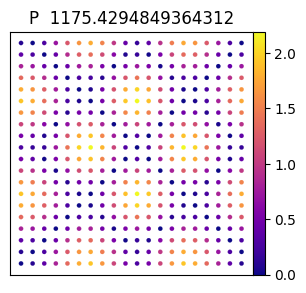

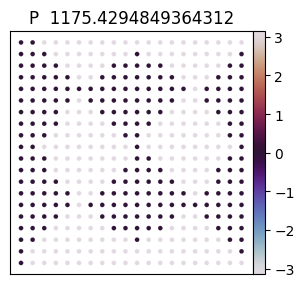

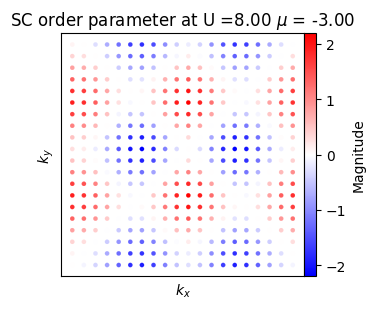

In [28]:
nk =20
nkf = 5
Us = "8.00"
model = "1NNN t' = 0. 75"
mus = "-3.00"
    


ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
mod.klabels=["G","M","X","G"]

out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)

/tmp/ipykernel_3223/4003043010.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


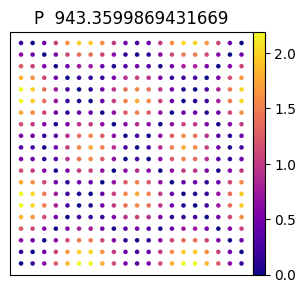

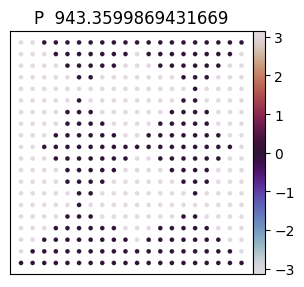

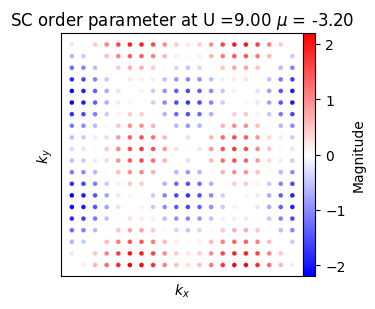

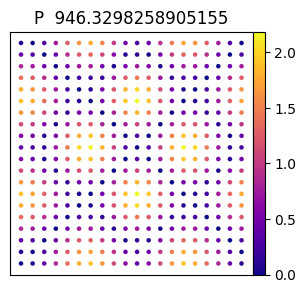

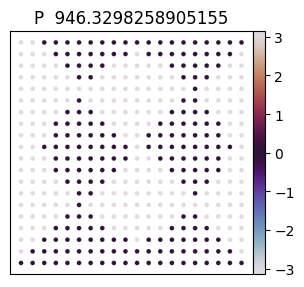

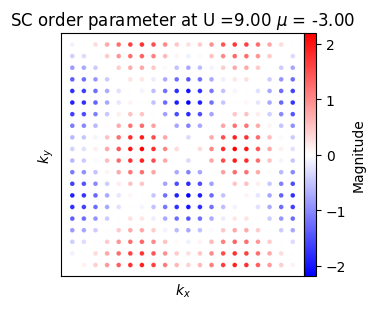

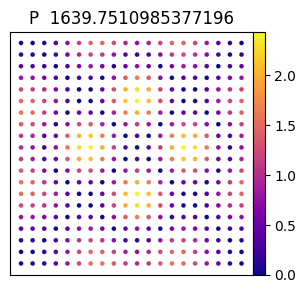

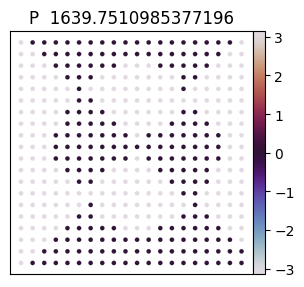

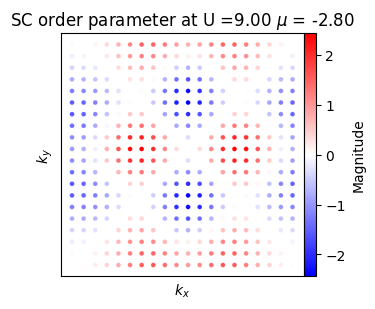

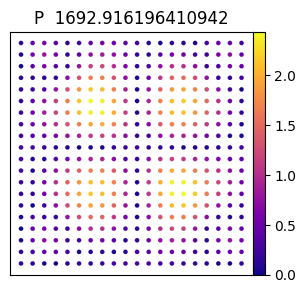

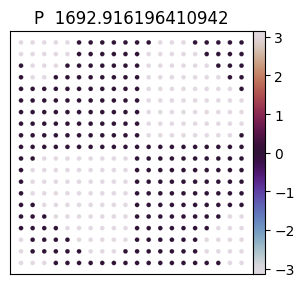

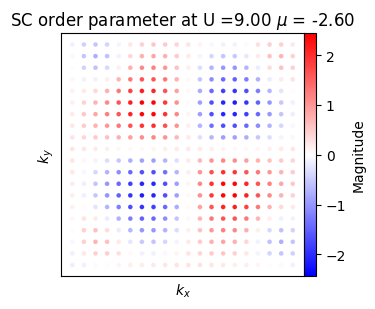

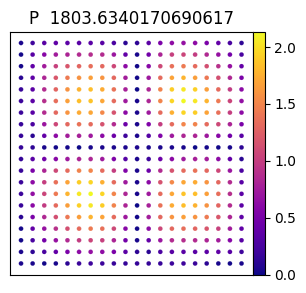

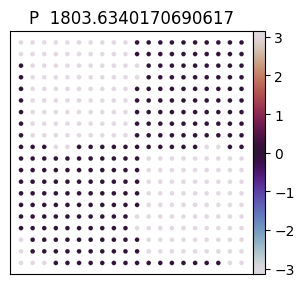

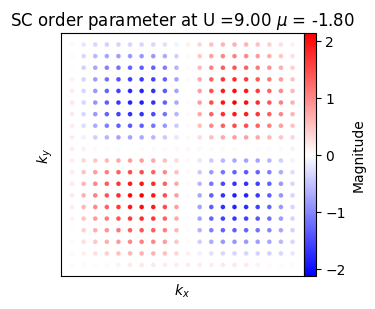

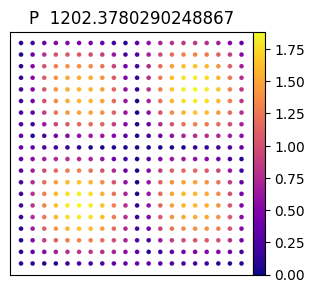

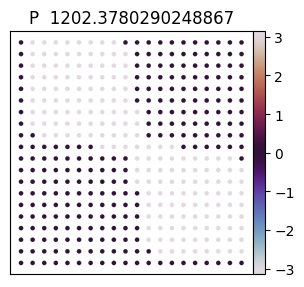

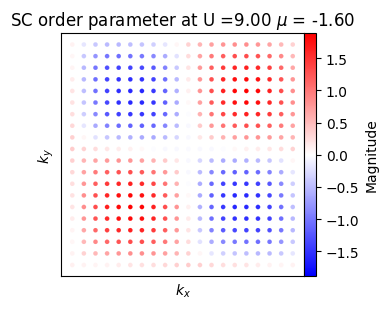

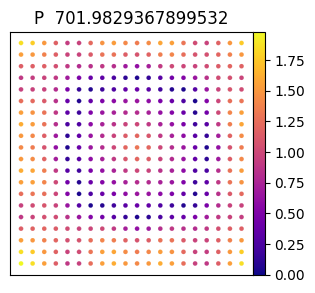

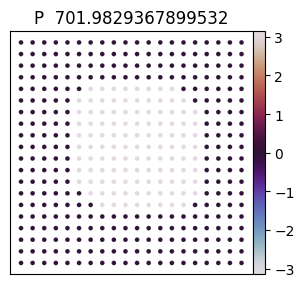

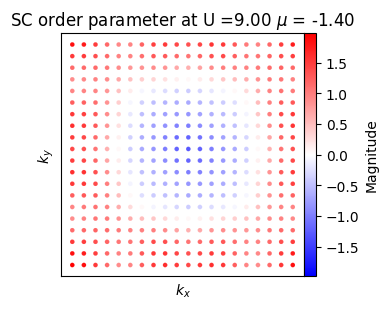

In [29]:
# SC parameter evolution:

# mu : -3.2, -3, -2.8, -2.6, -2.4 -2.2, -2.0, -1.8, -1.6, -1.4 

nk = 20 
nkf = 5
Us = "9.00"
model = "1NNN t' = 0. 75"
mu = ["-3.20", "-3.00", "-2.80", "-2.60", "-1.80", "-1.60", "-1.40" ]
    
for mus in mu: 

    ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
    mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
    mod.klabels=["G","M","X","G"]

    out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

    plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)

/tmp/ipykernel_3223/4003043010.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


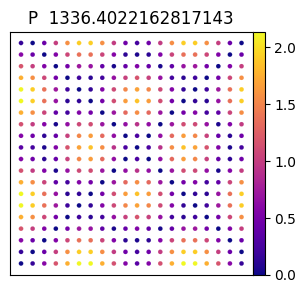

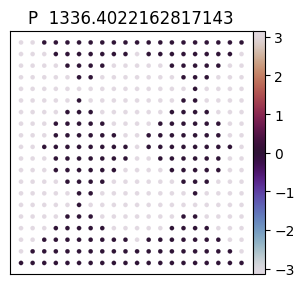

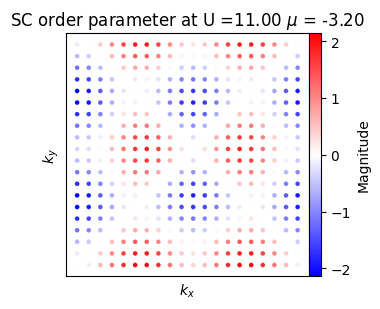

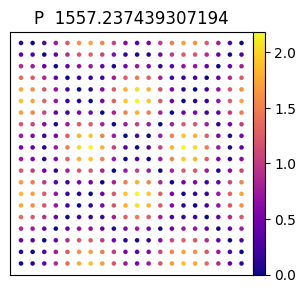

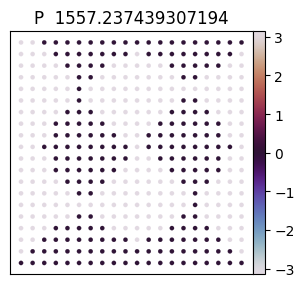

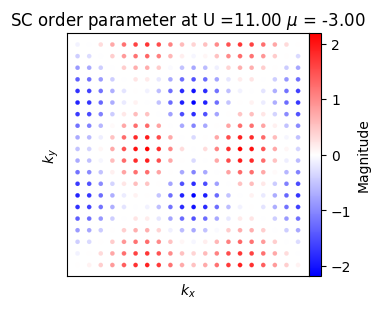

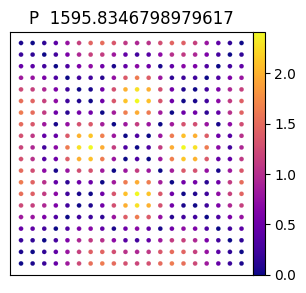

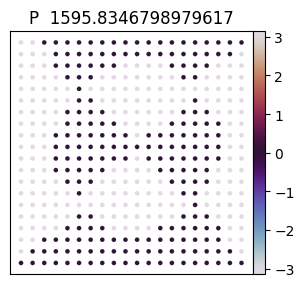

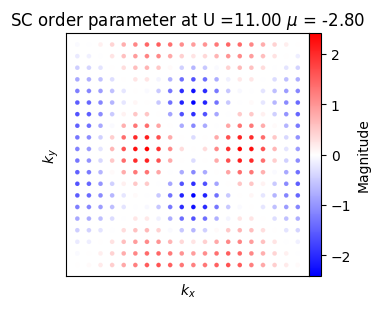

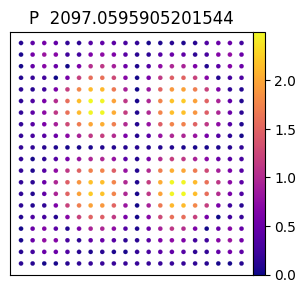

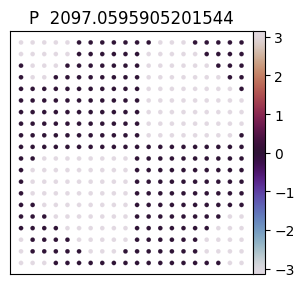

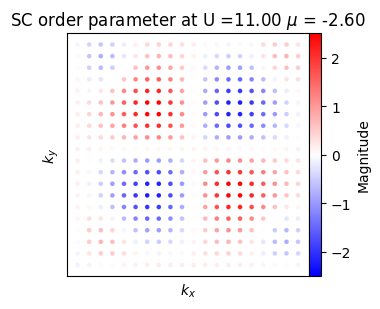

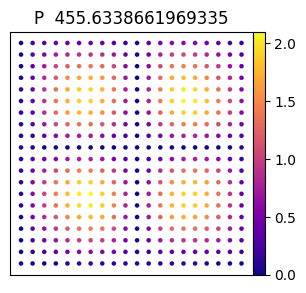

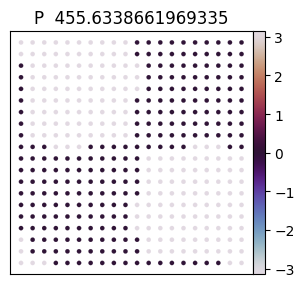

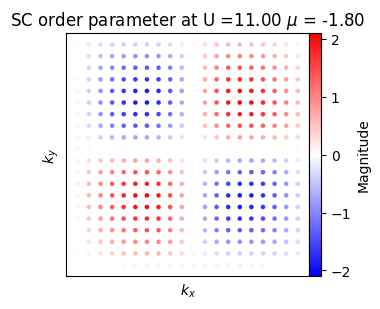

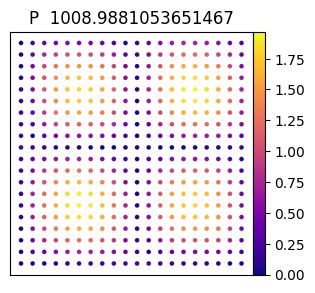

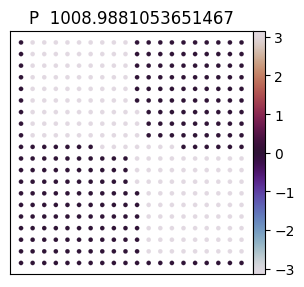

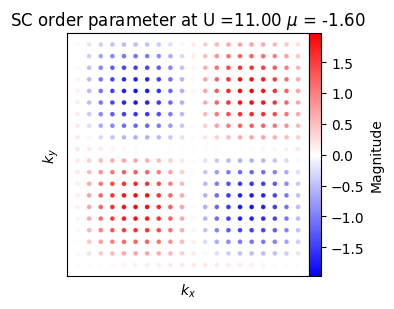

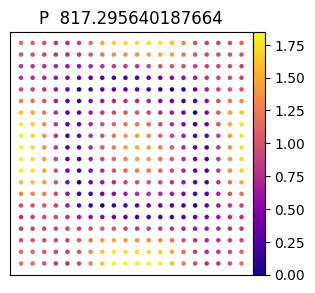

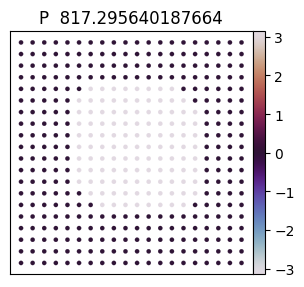

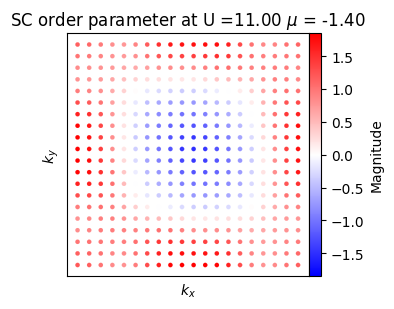

In [55]:
# SC parameter evolution:

# mu : -3.2, -3, -2.8, -2.6, -2.4 -2.2, -2.0, -1.8, -1.6, -1.4 

nk = 20 
nkf = 5
Us = "11.00"
model = "1NNN t' = 0. 75"
mu = ["-3.20", "-3.00", "-2.80", "-2.60", "-1.80", "-1.60", "-1.40" ]
    
for mus in mu: 

    ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
    mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
    mod.klabels=["G","M","X","G"]

    out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

    plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)

/tmp/ipykernel_3223/4003043010.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


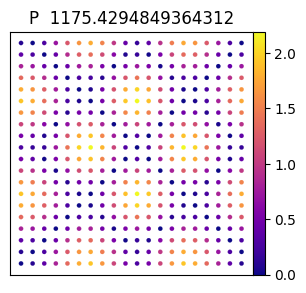

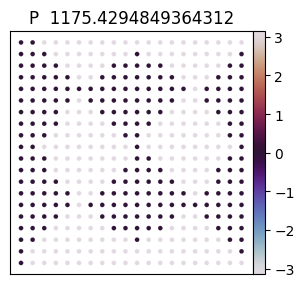

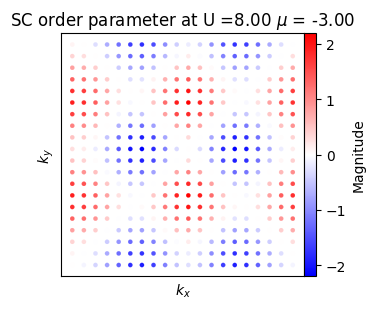

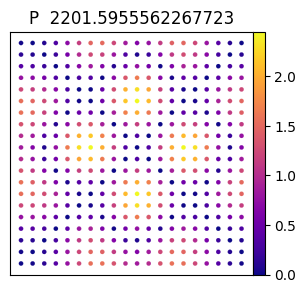

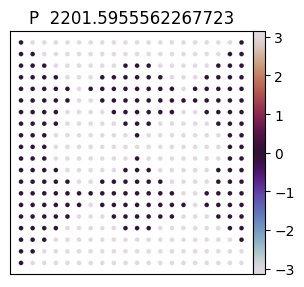

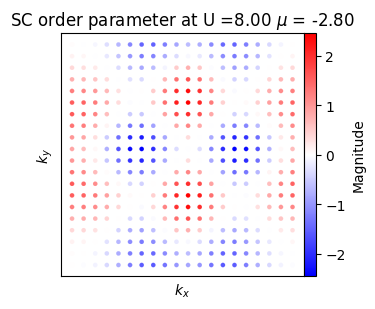

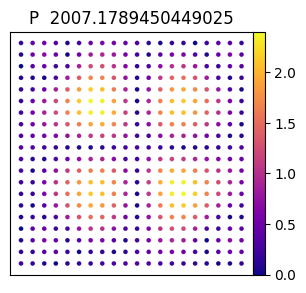

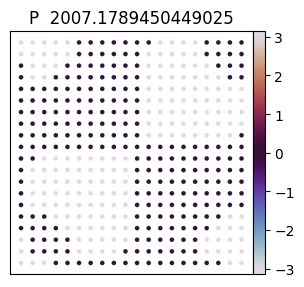

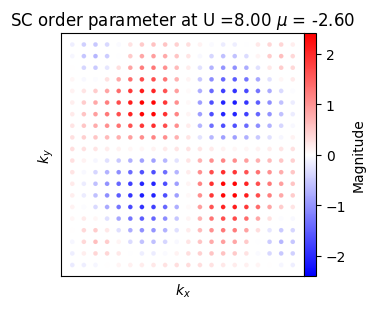

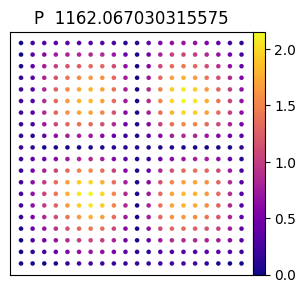

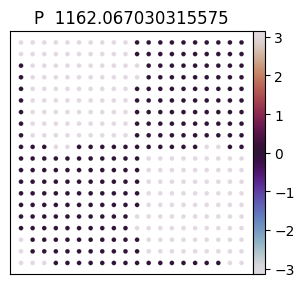

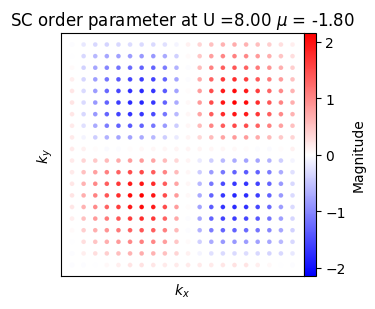

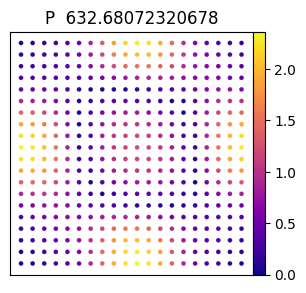

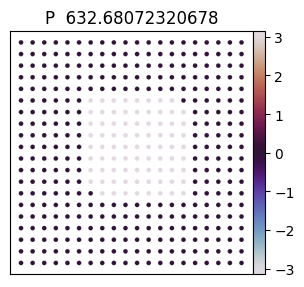

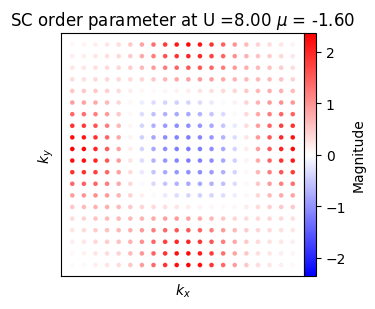

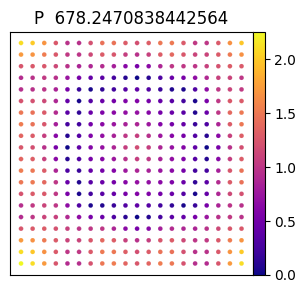

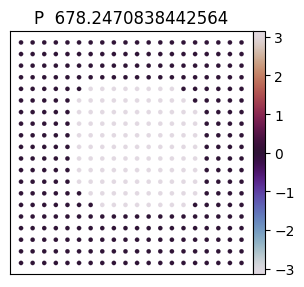

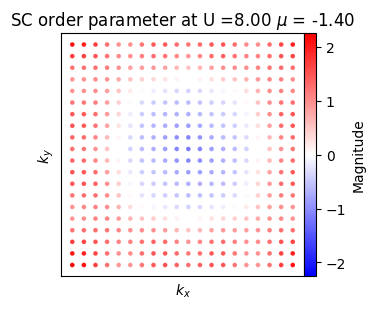

In [30]:
nk = 20 
nkf = 5
Us = "8.00"
model = "1NNN t' = 0. 75"
mu = ["-3.00", "-2.80", "-2.60", "-1.80", "-1.60", "-1.40" ]
    
for mus in mu: 

    ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
    mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
    mod.klabels=["G","M","X","G"]

    out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

    plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)

/tmp/ipykernel_3223/4003043010.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


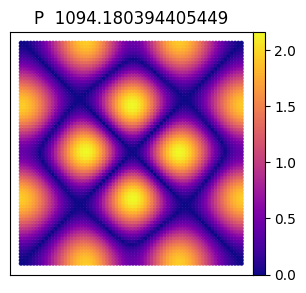

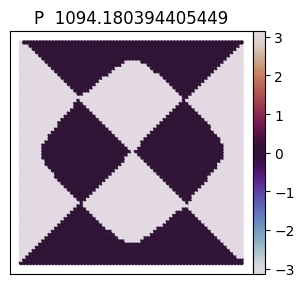

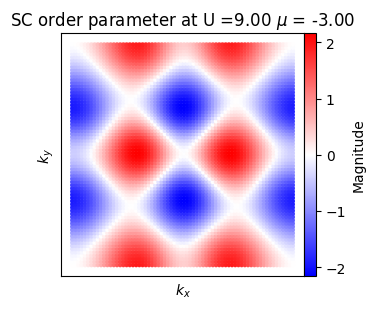

In [31]:
nk =70
nkf = 5
Us = "9.00"
model = "1NNN t' = 0. 75"
mus = "-3.00"
    


ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
mod.klabels=["G","M","X","G"]

out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)

In [32]:
def read_gap_file(filename):
        f = open(filename,"r")

        gap_parameters = []
        for line in f:
            l = line.split()
            Rx = float(l[0])
            Ry = float(l[1])
            Rz = float(l[2])
            orb1 = int(l[3])
            orb2 = int(l[4])
            Re = float(l[5])
            Im = float(l[6])
            gap_parameters.append([Rx,Ry,Rz,orb1,orb2,Re,Im])
        return gap_parameters






def plot_gap_file(filename):
        gap_parameters = np.array(read_gap_file(filename))

        Rx_max = int(np.max(gap_parameters[:,0]))
        Rx_min = int(np.min(gap_parameters[:,0]))

        Ry_max = int(np.max(gap_parameters[:,1]))
        Ry_min = int(np.min(gap_parameters[:,1]))

        Rz_max = int(np.max(gap_parameters[:,2]))
        Rz_min = int(np.min(gap_parameters[:,2]))

        n_bands = int(np.max(gap_parameters[:,4])+1)
        Rx_size = (Rx_max - Rx_min)
        Ry_size = (Ry_max - Ry_min)
        Rz_size = (Rz_max - Rz_min)

        MAT = np.zeros((Rx_size+1,Ry_size+1))
        total_array = [[np.zeros((Rx_size+1,Ry_size+1)) for i in range(n_bands)] for j in range(n_bands)]

        for gap in gap_parameters:
            Rx = int(gap[0])
            Ry = int(gap[1])
            Rz = int(gap[2])
            orb1 = int(gap[3])
            orb2 = int(gap[4])
            Re = gap[5]
            Im = gap[6]
            total_array[orb1][orb2][int(Rx-Rx_min)][int(Ry-Ry_min)] = Re

        #print(np.array(total_array).shape)

        #make a 3x3 subplot graph
        if (n_bands == 1):
            fig, ax = plt.subplots(1,1)
            ax.matshow(total_array[0][0],cmap="RdBu",vmin=-0.1,vmax=0.1)
            ax.set_xticks(np.arange(Rx_size+1))
            ax.set_xticklabels(np.arange(Rx_min,Rx_max+1))
            ax.set_yticks(np.arange(Ry_size+1))
            ax.set_yticklabels(np.arange(Ry_min,Ry_max+1))
        else:
            fig, ax = plt.subplots(n_bands,n_bands)
            for i in range(n_bands):
                for j in range(n_bands):
                    ax[i][j].matshow(total_array[i][j],cmap="RdBu",vmin=-0.1,vmax=0.1)
                    ax[i][j].set_xticks(np.arange(Rx_size+1))
                    ax[i][j].set_xticklabels(np.arange(Rx_min,Rx_max+1))
                    ax[i][j].set_yticks(np.arange(Ry_size+1))
                    ax[i][j].set_yticklabels(np.arange(Ry_min,Ry_max+1))

        #cm =plt.matshow(total_array[2][2],cmap="RdBu")
        #plt.colorbar(cm)
        #plt.xticks(np.arange(Rx_size+1),np.arange(Rx_min,Rx_max+1))
        #plt.yticks(np.arange(Ry_size+1),np.arange(Ry_min,Ry_max+1))
        plt.show()

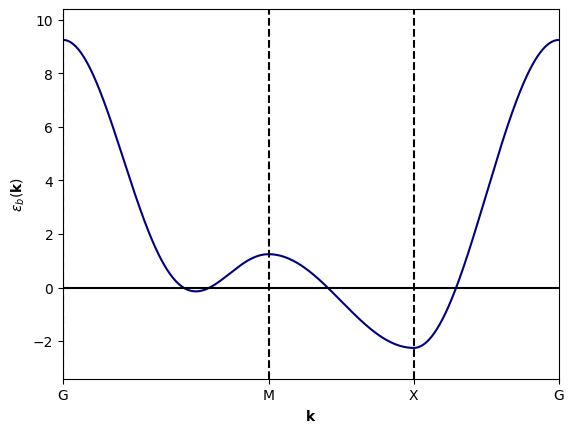

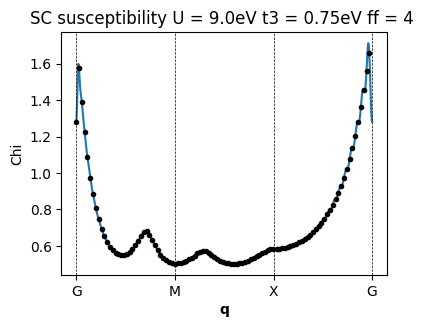

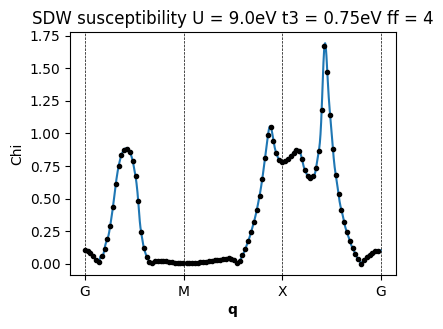

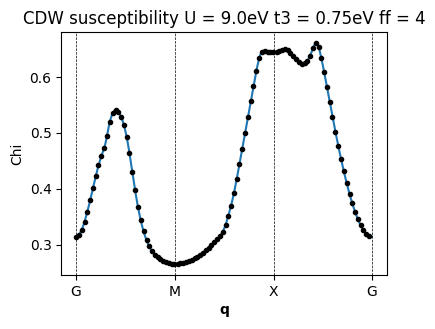

/tmp/ipykernel_3223/4003043010.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


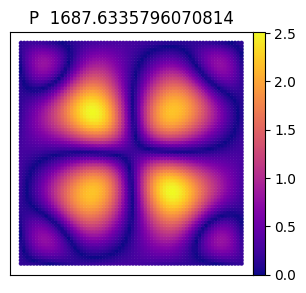

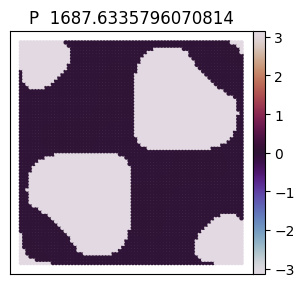

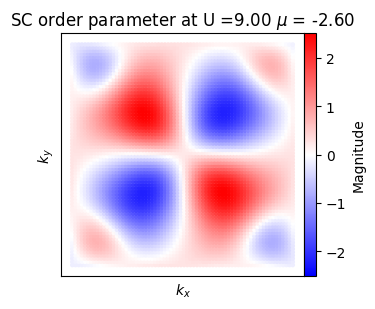

/tmp/ipykernel_3223/681225912.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


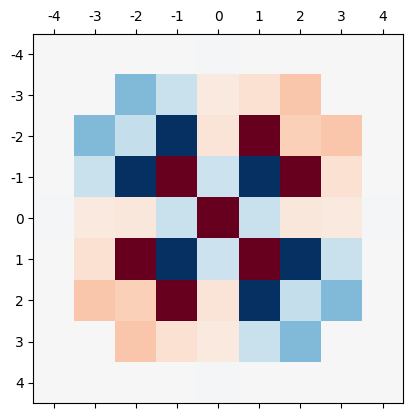

In [33]:


mod = do.read(f"1NN_70_5_9.00_-2.60_mod.dvg")
mod.klabels=["G","M","X","G"]
plotBandStructure(mod,save=False)
    #exit(0)
out = do.read(f"1NN_70_5_9.00_-2.60_out.dvg")

U = 9.00
t3 = 0.75
ff = 4
mu = -2.60



suscepPlot(mod,out,channel="P",title=f"U = {U}eV t3 = {t3}eV ff = {ff} ")
suscepPlot(mod,out,channel="C",title=f"U = {U}eV t3 = {t3}eV ff = {ff}")
suscepPlot(mod,out,channel="D",title=f"U = {U}eV t3 = {t3}eV ff = {ff}")
plt.show()


plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0],"9.00", "-2.60", "plot", real_space=False)
plt.show()
save_SCgap(out,mod,"P",out.Pvec[0],gap_file=f"gap_file_t{t3}_mu{mu}_U{U}_ff{ff}.txt")
plot_gap_file(f"gap_file_t{t3}_mu{mu}_U{U}_ff{ff}.txt")
    



In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from numpy import linalg as LA

import numba as nb 

import time  

#change directory to the directory of the script.
import os
#change to directory of current script



class tbModifer():

    r'''
    This class is used to load and store the tight binding Hamiltonian. It can also be used to load the eigenvalues and eigenvectors over a k-grid.
    '''

    def __init__(self, filename,isSpinPolarised=False,hasSOC=False,hasRashbaSOC=False,isSuperconducting=False):
        self.path = filename
        self.filename = filename.split("/")[-1]

        self.nbands = 0
        self.Orbital_Label = []
        self.Orbital_Colour = []
        self.MixOrbitalWeights = None
        self.Orbital_Repetition = 0
        self.lattice_vectors = np.array([[1.0,0,0],[0,1.0,0],[0,0,1.0]],dtype=np.float64)
        self.reciprocal_vectors = self.get_reciprocal_vectors(self.lattice_vectors)
       
        self.FermiEnergy = 0.0
        self.hopping_parameters = []
        self.GapRemoval = []
        self.R_degeneracy = []
        self.SOChopping_parameters = [] #SOC matrices also written in same format as hopping parameters. L dot S
        self.RashbaSOChopping_parameters = [] # Rashba SOC matrices also written in same format as hopping parameters.  Lx sigma_y - Ly sigma_x
        self.FermiEnergy_hoppings =[]
        self.ferromagnetic_hoppings =[] 
        self.antiferromagnetic_hoppings =[]
        self.SC_gap_hopping = []
        self.particle_hoppings = []
        self.hole_hoppings = []

        self.SpinPolarised = isSpinPolarised
        self.SOC = hasSOC
        self.SOCstrength = 0.0
        self.RashbaSOC = hasRashbaSOC
        self.RashbaSOCstrength = 0.0
        self.ExchangeSplitting = 0.0
        self.Superconducting = isSuperconducting
        self.CurrentTemperature = 1

        self.read_hoppings() #This needs to be exactly here. Above Fermi energy, but below everything else.

        self.atomic_info = []

    def read_hoppings(self):
        """
        This function reads a Wannier90 formatted tight binding model file. Often saved as XXX_hr.dat.
        If this doesn't work, nothing will.
        importantly it reads 
         - self.nbands : number of bands/orbitals in the model (size of the hamiltonian).
         - self.hopping_parameters : a list of [Rx,Ry,Rz,orbital_index_1,orbital_index_2,Re(t),Im(t),Rdegeneracy] where Re(t) and Im(t) are the real and imaginary parts of the hopping parameter that connecting two orbitals seperated by a unit cell vector R = [Rx,Ry,Rz]. 
        Unfortunately, R_degeneracy is needed in Wannier90. You have to divide each hopping parameter by the R_degeneracy value that corresponds to the specific R-vector.
        see e.g http://www.wanniertools.com/input.html#wannier90-dat
        """
        self.hopping_parameters = []
        self.R_degeneracy = []
        f = open(self.path, "r")
        count = 0
        PASS = False
        Rlast=0
        R_counter=0
        for line in f:
            l = line.split()
            #print(count,l)
            if count == 1:
                self.nbands = int(l[0]) #number of bands/Hamiltonian size
            elif count == 2:
                self.Rnum = int(l[0]) # number of unique R-vectors
            elif count ==3:
                lenl = len(l)
                for i in l:
                    self.R_degeneracy.append(float(i)) # This is the list of numbers usually in rows of 15 numbers. 

            elif count > 3:
                if (len(self.R_degeneracy) < self.Rnum):
                    for i in l:
                        self.R_degeneracy.append(float(i))
                else:
                    if len(l) > 0:
                        #Rx Ry Rz s p tr ti
                        #This is to determine what the R-degeneracy of the hopping parameter is.
                        if Rlast ==0:
                            Rlast = [float(l[0]),float(l[1]),float(l[2])]
                        R = [float(l[0]),float(l[1]),float(l[2])]

                        if R != Rlast:
                            R_counter +=1
                            Rlast = R

                        if ((float(l[5]) != 0) or (float(l[6]) !=0)): #Dont add in zeros, that just slows things down.
                            self.hopping_parameters.append([float(l[0]),float(l[1]),float(l[2]),float(l[3]),float(l[4]),float(l[5])/self.R_degeneracy[R_counter],float(l[6])/self.R_degeneracy[R_counter]])
                        #print(HAM[-1])
            count += 1
        self.hopping_parameters = self.hopping_parameters
        self.R_degeneracy = self.R_degeneracy

    
    def DefineOrbitals(self,OrbitalLabel,OrbitalColour,MixOrbitalWeights=None):
        """
        If you have a model with multiple orbitals, you can give each orbital index a label and colour using this function.
        This is needed if you want to plot orbital resolved functions. You will recieve an error if you have not called this function. 
        Eventually I will make it so that the initial Hamiltonian text file will contain this information. 

        If you have multiple repeated orbital indices. (e.g 2 atoms at different positions with the same orbitals) just write it out once and then the code will repeat it.  
        example: OrbitalLabel = [dxz,dyz,dxy] OrbitalColour = [red,blue,green] would work for a one atom three band model, or a two atom six band model, where index 1 and 4 will be "dxz" and coloured red. 

        MixOrbitalWeights tells the rest of the code whether you want to display the Maximum orbital character of e.g the bandstructure. Or if you want to mix the colours together to get a smoother evolution of the colours. 
        """
        #check orbitalLabel and ORbital Color are lists of the same length.
        if len(OrbitalLabel) != len(OrbitalColour):
            print("OrbitalLabel and OrbitalColor must be lists of the same length")
            return 0
        #check the list supplied is a multiple of the number of bands.
        if self.nbands%len(OrbitalLabel) != 0:
            print("OrbitalLabel and OrbitalColor must be the same size as either the number of orbitals, or some fraction of the number of orbitals")
            print("Number of bands / length of OrbitalLabel = ",self.nbands/len(OrbitalLabel))
            return 0
        if len(self.Orbital_Colour) != 0:
            self.Orbital_Colour.clear
            self.Orbital_Label.clear
            self.Orbital_Repetition = 0

        else:
            for orb_colour in OrbitalColour: # Convert to tuple
                self.Orbital_Colour.append(colors.to_rgb(orb_colour))

            self.Orbital_Repetition = self.nbands/len(OrbitalLabel)
            self.Orbital_Label = OrbitalLabel
            if MixOrbitalWeights != None:
                self.MixOrbitalWeights = True

    def DefineLatticeVectors(self,lattice_vectors):
        """
        This function is used to define the lattice vectors of the system.
        If not called the system assumes cubic lattice vectors with the lattice constant set to 1. 
        If you define this, you can use symmetry to identify the irreducible brillouin zone (thus speeding up calculations) and will get the correct Brillouin zone boundaries.
        You can check this is correct by using self.show_Kpoints_and_BrillouinZone() and checking the plot. 

        Lattice vectors should be a 3x3 matrix of the form [[a1,b1,c1],[a2,b2,c2],[a3,b3,c3]] where a,b,c are the three lattice vectors.
        """
        if type(lattice_vectors) == list:
            lattice_vectors = np.array(lattice_vectors,dtype=np.float64)
        
        if type(lattice_vectors) == np.ndarray:
            if lattice_vectors.shape == (2,2): #can put in 2D array, but we'll just extend to 3D
                new_lattice_vectors = np.zeros((3,3),dtype=np.float64) 
                for i in range(2):
                    for j in range(2):
                        new_lattice_vectors[i][j] = lattice_vectors[i][j]

            if lattice_vectors.shape == (3,3):
                self.lattice_vectors = np.array(lattice_vectors,dtype=np.float64)
                self.reciprocal_vectors = self.get_reciprocal_vectors(self.lattice_vectors)
               
    def DefineAtomicInfo(self,atoms):
        """
        If you have atoms with different positions and orbital characters, you can define them here. 
        Ideally I want this to be included in the hamiltonian input file. But for now that's not the case. 
        
        #This needs to be a list of list [[atom, [x,y,z],[orbital_index_1...orbital_index_n],[hamiltonian_index_1...hamiltonian_index_n]]
        #atom is a string that defines the name of the atom, can be anything you like. 
        #x,y,z are the positions of the atom in the unit cell, in units of the lattice vectors.
        #orbital_index_1...orbital_index_n are the orbital indices that correspond to the atom. # 0 s 1 px 2 py 3 pz 4 dz2 5 dxz 6 dyz 7 dx2-y2 8 dxy
        #hamiltonian_index_1...hamiltonian_index_n are the indices of the hopping parameters that correspond to the orbital. 
        # and example would be
        #[[Ru, [0.5,0.5,0.5],[5,6,8],[1,2,3]]] for a 3 band model of a single Ru atom at 0.5,0.5,0.5 with dxz,dyz,dxy orbitals.
         
        """
        if isinstance(atoms,Atom):
            try: atoms = [atoms]
            except:
                print("atoms must be a list:",atoms)
                return 0
        
        if isinstance(atoms,list):
            if not isinstance(atoms[0],Atom):
                print("atoms needs to be a list of Hamiltonian.Atom objects")
                exit(0)
        
        self.atomic_info = atoms

            

    def make_SpinPolarised(self):
        """
        Takes the model, checks if it's spin polarised, if not, doub les the number of bands and adds the spin polarised hopping parameters to the spin down channel.

        i.e takes H(k) and converts it into a 2x2 matrix of [[H(k)^up 0], [0, H(k)^down]].
        """
        if self.SpinPolarised == False:
            self.SpinPolarised = True
            #This makes the spin down block. 
            hopping_parameters = []
            for i in self.hopping_parameters:
                hopping_parameters.append([i[0],i[1],i[2],i[3]+self.nbands,i[4]+self.nbands,i[5],i[6]]) #Rx,Ry,Rz,s+nbands,p+nbands,tr,ti, Rdegeneracy (Rdegenearcy needed for Wannier90, but soon to become redundant)
            self.hopping_parameters = self.hopping_parameters+ hopping_parameters
            for i in range(self.nbands):
                self.FermiEnergy_hoppings.append([0.,0.,0.,i+self.nbands+1,i+self.nbands+1,-self.FermiEnergy,0.0])
            self.nbands = 2*self.nbands
    
    def make_Nambau(self):
        """
        Make normal tb model into a Nambau superconducting model. (H(k) = [[H(k),Delta(k)],[-Delta(k),-H(k)]])
        """

        if self.Superconducting == False:
            particle_hoppings = self.get_Hoppings()
            self.particle_hoppings = particle_hoppings
            hole_hoppings = np.copy(particle_hoppings)
            for i in range(len(hole_hoppings)):
                hole_hoppings[i][0] =  -particle_hoppings[i][0] #Rx
                hole_hoppings[i][1] =  -particle_hoppings[i][1] #Ry
                hole_hoppings[i][2] =  -particle_hoppings[i][2] #Rz
                hole_hoppings[i][3] =  particle_hoppings[i][3] + self.nbands #orb1
                hole_hoppings[i][4] =  particle_hoppings[i][4] + self.nbands #orb2
                hole_hoppings[i][5] = -particle_hoppings[i][5] #Re(t) # minus sign for holes
                hole_hoppings[i][6] = -particle_hoppings[i][6] #Im(t) minus sign for holes
            self.hole_hoppings = hole_hoppings
            self.nbands = 2*self.nbands


            self.Superconducting = True
        else:
            print("Model already superconducting")

    def add_SCgap_from_FRG(self,SCGap,delta=0.01):
        gap_parameters = self.read_gap_file(SCGap)
        if self.Superconducting == False:
            self.make_Nambau()

        self.SC_gap_hopping = []

        half_nbands = int(self.nbands/2)
        for gap in gap_parameters:
            Rx = gap[0]
            Ry = gap[1]
            Rz = gap[2]
            orb1 = gap[3]+1
            orb2 = gap[4]+1
            Re = gap[5]*delta
            Im = gap[6]*delta

            #if (Re != 0) or (Im != 0):
            #    print(Rx,Ry,Rz,orb1,orb2,Re,Im)
     
            self.SC_gap_hopping.append([Rx, Ry, Rz, orb1, orb2 + half_nbands, Re, Im])
            self.SC_gap_hopping.append([-Rx, -Ry, -Rz, orb2 + half_nbands, orb1, Re,-Im])#Hermitian conjugate
            
    def add_SOC(self):
        """
        #Takes a Hamiltonian, and adds atomic spin orbit coupling via. L.S 
        #Requires self.atom_info to be set. 
        #Hopefully this will automatically be done in the future hamiltonian files. 
        #Also can take into account that orbitals may not be positioned along the x,y,z axis of the unit cell. 
        """
        if self.SOC == True:
            print("SOC already added to model")
            return 0
        if self.SOC == False:
            self.SOC = True
            if self.SpinPolarised == False:
                self.make_SpinPolarised()
            #print("Done")
            
            SOChopping_parameters = []
                
            #self.SOCstrength = SOC_strength
            #SOC can be for any orbital pointing along any axis. need to take care of that by doing a rotation of the Lx,Ly and Lz matrices which are defined with respect to the a,b and c lattice directions. 
            for atom in self.atomic_info: #atom info should be atom_info[atom_index][0] = atom_name [1] = atom positions, [2] = orbital indices, [3] = hamiltonian indices
                #theta = np.pi / 4  # Example rotation angle
                v = np.array([1,0, 0])  #  x- axis to get in plane theta angle 
                w = np.array([atom.orientation[0],atom.orientation[1],0.0])  # project onto xy plane. 
                cos_theta = np.dot(v, w) / (np.linalg.norm(v) * np.linalg.norm(w))
                theta_rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))
                theta_deg = np.degrees(theta_rad)
                v = np.array([0,0, 1])  #  z- axis
                w = np.array([atom.orientation[0],0,atom.orientation[2]])  # project onto xz plane.
                cos_phi = np.dot(v, w) / (np.linalg.norm(v) * np.linalg.norm(w))
                phi_rad = np.arccos(np.clip(cos_phi, -1.0, 1.0))
                phi_deg = np.degrees(phi_rad)

                #First rotate the L angular momentum matrices with respect to the x-axis
                R_theta = np.array([[np.cos(theta_rad), -np.sin(theta_rad),0],
                            [np.sin(theta_rad), np.cos(theta_rad),0],
                            [0,0,1]])
                #Then rotate the L angular momentum matrices out of the xy plane. the -np.pi/2.0 is to rotate with respect to the xy plane. 
                R_phi = np.array([[np.cos(phi_rad-np.pi/2.0), 0, -np.sin(phi_rad-np.pi/2.0)], #
                            [0, 1, 0],
                            [np.sin(phi_rad-np.pi/2.0), 0, np.cos(phi_rad-np.pi/2.0)]])

                
                xxp,xyp,xzp = np.dot(R_phi,np.dot(R_theta,[1,0,0]))
                yxp,yyp,yzp = np.dot(R_phi,np.dot(R_theta,[0,1,0]))
                zxp,zyp,zzp = np.dot(R_phi,np.dot(R_theta,[0,0,1]))

                Lx_d_rotated = xxp*Lx_d + xyp*Ly_d + xzp*Lz_d
                Ly_d_rotated = yxp*Lx_d + yyp*Ly_d + yzp*Lz_d
                Lz_d_rotated = zxp*Lx_d + zyp*Ly_d + zzp*Lz_d

                Lx_p_rotated = xxp*Lx_p + xyp*Ly_p + xzp*Lz_p
                Ly_p_rotated = yxp*Lx_p + yyp*Ly_p + yzp*Lz_p
                Lz_p_rotated = zxp*Lx_p + zyp*Ly_p + zzp*Lz_p
            
                
                for orb1_i,orb1 in enumerate(atom.orbital_character): #This should be non SOC indices. 
                    for orb2_i,orb2 in enumerate(atom.orbital_character):
                        if (orb1 >3) and (orb2 >3): #D ORBITALS
                            #LZ
                            if np.abs(Lz_d_rotated[orb1-4][orb2-4]) > 0.0:
                                L = (atom.SOC_LdotS_D/2.0)*Lz_d_rotated[orb1-4][orb2-4] #atom.SOC_LdotS_D is the SOC strength for the d orbitals of this particular atom
                                Ham_index_1 = atom.hamiltonian_indices[orb1_i]
                                Ham_index_2 = atom.hamiltonian_indices[orb2_i]
                                SOChopping_parameters.append([0.,0.,0.,Ham_index_1,Ham_index_2,L.real,L.imag]) #H_up_up
                                SOChopping_parameters.append([0.,0.,0.,Ham_index_1+int(self.nbands/2.0),Ham_index_2+int(self.nbands/2.0),-L.real,-L.imag])  #H_down_down
                            #LX +iLY 
                            if (np.abs(Lx_d_rotated[orb1-4][orb2-4]) > 0.0) or np.abs(Ly_d_rotated[orb1-4][orb2-4]) > 0.0:
                                L_updown = (atom.SOC_LdotS_D/2.0)*(Lx_d_rotated[orb1-4][orb2-4] + 1j*Ly_d_rotated[orb1-4][orb2-4])
                                L_downup = (atom.SOC_LdotS_D/2.0)*(Lx_d_rotated[orb1-4][orb2-4] - 1j*Ly_d_rotated[orb1-4][orb2-4]) #Hermitian conjugate
                                Ham_index_1 = atom.hamiltonian_indices[orb1_i]
                                Ham_index_2 = atom.hamiltonian_indices[orb2_i]
                                #Check this is the right way round!
                                SOChopping_parameters.append([0.,0.,0.,Ham_index_1,Ham_index_2+int(self.nbands/2.0),L_updown.real,L_updown.imag]) 
                                SOChopping_parameters.append([0.,0.,0.,Ham_index_1+int(self.nbands/2.0),Ham_index_2,L_downup.real,L_downup.imag]) 
                        elif (0 <orb1 < 4 ) and (0 < orb2 < 4): #P ORBITALS
                            #LZ
                            if np.abs(Lz_p_rotated[orb1-1][orb2-1]) > 0.0:
                                L = (atom.SOC_LdotS_P/2.0)*Lz_p_rotated[orb1-1][orb2-1] #atom.SOC_LdotS_P is the SOC strength for the p orbitals of this particular atom
                                Ham_index_1 = atom.hamiltonian_indices[orb1_i]
                                Ham_index_2 = atom.hamiltonian_indices[orb2_i]
                                SOChopping_parameters.append([0.,0.,0.,Ham_index_1,Ham_index_2,L.real,L.imag,1.0]) #H_up_up
                                SOChopping_parameters.append([0.,0.,0.,Ham_index_1+int(self.nbands/2.0),Ham_index_2+int(self.nbands/2.0),-L.real,-L.imag])  #H_down_down
                            #LX +iLY 
                            if (np.abs(Lx_p_rotated[orb1-1][orb2-1]) > 0.0) or np.abs(Ly_p_rotated[orb1-1][orb2-1]) > 0.0:
                                L_updown = (atom.SOC_LdotS_P/2.0)*(Lx_p_rotated[orb1-1][orb2-1] + 1j*Ly_p_rotated[orb1-1][orb2-1])
                                L_downup = (atom.SOC_LdotS_P/2.0)*(Lx_p_rotated[orb1-1][orb2-1] - 1j*Ly_p_rotated[orb1-1][orb2-1]) #Hermitian conjugate
                                Ham_index_1 = atom.hamiltonian_indices[orb1_i]
                                Ham_index_2 = atom.hamiltonian_indices[orb2_i]
                                #Check this is the right way round!
                                SOChopping_parameters.append([0.,0.,0.,Ham_index_1,Ham_index_2+int(self.nbands/2.0),L_updown.real,L_updown.imag]) 
                                SOChopping_parameters.append([0.,0.,0.,Ham_index_1+int(self.nbands/2.0),Ham_index_2,L_downup.real,L_downup.imag]) 
                        
            self.SOChopping_parameters = SOChopping_parameters
            #print(self.SOChopping_parameters)

    def add_RashbaSOC(self):
        """
        #Takes a Hamiltonian, and adds atomic spin orbit coupling via. L.S 
        #Requires self.atom_info to be set. 
        #Hopefully this will automatically be done in the future hamiltonian files. 
        #Also can take into account that orbitals may not be positioned along the x,y,z axis of the unit cell. 
        """

        if self.RashbaSOC == False:
            self.RashbaSOC = True
            if self.SpinPolarised == False:
                self.make_SpinPolarised()

        RashbaSOChopping_parameters = []
            
        #self.RashbaSOCstrength = SOC_strength

        for atom in self.atomic_info: #atom info should be atom_info[atom_index][0] = atom_name [1] = atom positions, [2] = orbital indices, [3] = hamiltonian indices
            #theta = np.pi / 4  # Example rotation angle
            v = np.array([1,0, 0])  #  x- axis to get in plane theta angle 
            w = np.array([atom.orientation[0],atom.orientation[1],0.0])  # project onto xy plane. 
            cos_theta = np.dot(v, w) / (np.linalg.norm(v) * np.linalg.norm(w))
            theta_rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))
            theta_deg = np.degrees(theta_rad)
            #print(theta_deg)
            v = np.array([0,0, 1])  #  z- axis
            w = np.array([atom.orientation[0],0,atom.orientation[2]])  # project onto xz plane.
            cos_phi = np.dot(v, w) / (np.linalg.norm(v) * np.linalg.norm(w))
            phi_rad = np.arccos(np.clip(cos_phi, -1.0, 1.0))
            phi_deg = np.degrees(phi_rad)
            #exit(0)
            #First rotate the L angular momentum matrices with respect to the x-axis
            R_theta = np.array([[np.cos(theta_rad), -np.sin(theta_rad),0],
                        [np.sin(theta_rad), np.cos(theta_rad),0],
                        [0,0,1]])
            #Then rotate the L angular momentum matrices out of the xy plane. the -np.pi/2.0 is to rotate with respect to the xy plane. 
            R_phi = np.array([[np.cos(phi_rad-np.pi/2.0), 0, -np.sin(phi_rad-np.pi/2.0)], #
                        [0, 1, 0],
                        [np.sin(phi_rad-np.pi/2.0), 0, np.cos(phi_rad-np.pi/2.0)]])


            xxp,xyp,xzp = np.dot(R_phi,np.dot(R_theta,[1,0,0]))
            yxp,yyp,yzp = np.dot(R_phi,np.dot(R_theta,[0,1,0]))
            zxp,zyp,zzp = np.dot(R_phi,np.dot(R_theta,[0,0,1]))

            Sigma_x_rotated = xxp*Sigma_x + xyp*Sigma_y + xzp*Sigma_z
            Sigma_y_rotated = yxp*Sigma_x + yyp*Sigma_y + yzp*Sigma_z
            Sigma_z_rotated = zxp*Sigma_x + zyp*Sigma_y + zzp*Sigma_z

            for orb1_i,orb1 in enumerate(atom.orbital_character): #This should be non SOC indices.
                Ham_index = atom.hamiltonian_indices[orb1_i]
                Rashba_sigmax_01 = -1j*(atom.SOC_Rashba_D/2.0)*Sigma_x_rotated[0,1]
                Rashba_sigmax_10 = -1j*(atom.SOC_Rashba_D/2.0)*Sigma_x_rotated[1,0]
                #+dy sigma_x  
                RashbaSOChopping_parameters.append([0,1,0.,Ham_index,Ham_index+int(self.nbands/2.0),Rashba_sigmax_01.real,Rashba_sigmax_01.imag])
                RashbaSOChopping_parameters.append([0,1,0.,Ham_index+int(self.nbands/2.0),Ham_index,Rashba_sigmax_10.real,Rashba_sigmax_10.imag])
                #-dy sigma_x  
                RashbaSOChopping_parameters.append([0,-1,0.,Ham_index,Ham_index+int(self.nbands/2.0),-Rashba_sigmax_01.real,-Rashba_sigmax_01.imag])
                RashbaSOChopping_parameters.append([0,-1,0.,Ham_index+int(self.nbands/2.0),Ham_index,-Rashba_sigmax_10.real,-Rashba_sigmax_10.imag]) 

                #dx sigma_y
                Rashba_sigmay_01 = -1j*(atom.SOC_Rashba_D/2.0)*Sigma_y_rotated[0,1]
                Rashba_sigmay_10 = -1j*(atom.SOC_Rashba_D/2.0)*Sigma_y_rotated[1,0]
                RashbaSOChopping_parameters.append([ 1,0,0.,Ham_index,Ham_index+int(self.nbands/2.0),Rashba_sigmay_01.real,Rashba_sigmay_01.imag])
                RashbaSOChopping_parameters.append([ 1,0,0.,Ham_index+int(self.nbands/2.0),Ham_index,Rashba_sigmay_10.real,Rashba_sigmay_10.imag]) 
 
                RashbaSOChopping_parameters.append([-1,0.,0.,Ham_index,Ham_index+int(self.nbands/2.0),-Rashba_sigmay_01.real,-Rashba_sigmay_01.imag]) 
                RashbaSOChopping_parameters.append([-1,0.,0.,Ham_index+int(self.nbands/2.0),Ham_index,-Rashba_sigmay_10.real,-Rashba_sigmay_10.imag])  

            self.RashbaSOChopping_parameters = RashbaSOChopping_parameters
        
    def set_FermiEnergy(self,FermiEnergy):
        """
        allows you to change the checical potential.
        """
        self.FermiEnergy = FermiEnergy
        self.FermiEnergy_hoppings = []
        if self.Superconducting == True:
            half_nbands = int(self.nbands/2)
            for i in range(half_nbands):
                self.FermiEnergy_hoppings.append([0.,0.,0.,i+1,i+1,FermiEnergy,0.0])
                self.FermiEnergy_hoppings.append([0.,0.,0.,i+1+half_nbands,i+1+half_nbands,-FermiEnergy,0.0])
        else:
            for i in range(self.nbands):
                self.FermiEnergy_hoppings.append([0.,0.,0.,i+1,i+1,-FermiEnergy,0.0])

    def add_AntiFerromagnetism(self,magnetisation_strength_ev=0.0):
        if self.SpinPolarised == False:
                self.make_SpinPolarised()
        self.AntiFerromagnetism = magnetisation_strength_ev
        self.antiferromagnetic_hoppings = []

        #To be implemented

    def renormalise_hoppings(self,renormalisation_factor):
        """
        Crude renormalisation of the hopping parameters. multiplies all of the hopping parameters by a value Z, where Z is between 0 and 1. 
        """
        if renormalisation_factor > 1.0:
            print(f"your renormalisation factor ({renormalisation_factor}) should be between 0 and 1 ")
            return 0
        
        for i in range(len(self.hopping_parameters)):
            self.hopping_parameters[i][5] = self.hopping_parameters[i][5]*renormalisation_factor
            self.hopping_parameters[i][6] = self.hopping_parameters[i][6]*renormalisation_factor

        for i in range(len(self.antiferromagnetic_hoppings)):
            self.antiferromagnetic_hoppings[i][5] = self.antiferromagnetic_hoppings[i][5]*renormalisation_factor
            self.antiferromagnetic_hoppings[i][6] = self.antiferromagnetic_hoppings[i][6]*renormalisation_factor

        for i in range(len(self.ferromagnetic_hoppings)):
            self.ferromagnetic_hoppings[i][5] = self.ferromagnetic_hoppings[i][5]*renormalisation_factor
            self.ferromagnetic_hoppings[i][6] = self.ferromagnetic_hoppings[i][6]*renormalisation_factor

        print("model renormalised by a factor of ",(1.0/renormalisation_factor))
    

    def plot_gap_file(self,filename):
        gap_parameters = np.array(self.read_gap_file(filename))

        Rx_max = int(np.max(gap_parameters[:,0]))
        Rx_min = int(np.min(gap_parameters[:,0]))

        Ry_max = int(np.max(gap_parameters[:,1]))
        Ry_min = int(np.min(gap_parameters[:,1]))

        Rz_max = int(np.max(gap_parameters[:,2]))
        Rz_min = int(np.min(gap_parameters[:,2]))

        n_bands = int(np.max(gap_parameters[:,4])+1)
        Rx_size = (Rx_max - Rx_min)
        Ry_size = (Ry_max - Ry_min)
        Rz_size = (Rz_max - Rz_min)

        MAT = np.zeros((Rx_size+1,Ry_size+1))
        total_array = [[np.zeros((Rx_size+1,Ry_size+1)) for i in range(n_bands)] for j in range(n_bands)]

        for gap in gap_parameters:
            Rx = int(gap[0])
            Ry = int(gap[1])
            Rz = int(gap[2])
            orb1 = int(gap[3])
            orb2 = int(gap[4])
            Re = gap[5]
            Im = gap[6]
            total_array[orb1][orb2][int(Rx-Rx_min)][int(Ry-Ry_min)] = Re

        #print(np.array(total_array).shape)

        #make a 3x3 subplot graph
        if (n_bands == 1):
            fig, ax = plt.subplots(1,1)
            ax.matshow(total_array[0][0],cmap="RdBu",vmin=-0.1,vmax=0.1)
            ax.set_xticks(np.arange(Rx_size+1))
            ax.set_xticklabels(np.arange(Rx_min,Rx_max+1))
            ax.set_yticks(np.arange(Ry_size+1))
            ax.set_yticklabels(np.arange(Ry_min,Ry_max+1))
        else: 
            fig, ax = plt.subplots(n_bands,n_bands)
            for i in range(n_bands):
                for j in range(n_bands):
                    ax[i][j].matshow(total_array[i][j],cmap="RdBu",vmin=-0.1,vmax=0.1)
                    ax[i][j].set_xticks(np.arange(Rx_size+1))
                    ax[i][j].set_xticklabels(np.arange(Rx_min,Rx_max+1))
                    ax[i][j].set_yticks(np.arange(Ry_size+1))
                    ax[i][j].set_yticklabels(np.arange(Ry_min,Ry_max+1))

        #cm =plt.matshow(total_array[2][2],cmap="RdBu") 
        #plt.colorbar(cm)
        #plt.xticks(np.arange(Rx_size+1),np.arange(Rx_min,Rx_max+1))
        #plt.yticks(np.arange(Ry_size+1),np.arange(Ry_min,Ry_max+1))
        plt.show()

        
        #find maximum of first element in list

    
    def read_gap_file(self,filename):
        f = open(filename,"r")

        gap_parameters = []
        for line in f:
            l = line.split()
            Rx = float(l[0])
            Ry = float(l[1])
            Rz = float(l[2])
            orb1 = int(l[3])
            orb2 = int(l[4])
            Re = float(l[5])
            Im = float(l[6])
            gap_parameters.append([Rx,Ry,Rz,orb1,orb2,Re,Im])
        return gap_parameters

    def add_Ferromagnetism(self,magnetisation_strength_ev=0.0):
        if self.SpinPolarised == False:
                self.make_SpinPolarised()
        self.Ferromagnetism = magnetisation_strength_ev
        self.ferromagnetic_hoppings = []

        half_nbands = int(self.nbands/2)
        for i in range(half_nbands): #for FM, magnetisation goes on + in the spin up block and - in the spin down block.
            self.ferromagnetic_hoppings.append([0.,0.,0.,i+1,i+1,magnetisation_strength_ev,0.0]) #spin up
            self.ferromagnetic_hoppings.append([0.,0.,0.,i+1+half_nbands,i+1+half_nbands,-magnetisation_strength_ev,0.0]) #spin down


    def get_reciprocal_vectors(self,lattice_vectors):
        return 2*np.pi*LA.inv(lattice_vectors).T

    def get_Hoppings(self):
        """
        Takes all the different terms, e.g spin orbit coupling, superconductivity, chemical potential, which go into the Hamiltonian and returns the output as a single list to be used in H(k) = sum_R e^(i k.R) t(R)
        """
        if self.Superconducting == False:
            return np.array(list(self.hopping_parameters)
                            +list(self.SOChopping_parameters)
                            +list(self.GapRemoval) 
                            + list(self.FermiEnergy_hoppings) 
                            + list(self.RashbaSOChopping_parameters) 
                            + list(self.ferromagnetic_hoppings)
                            + list(self.antiferromagnetic_hoppings),dtype=np.float32)
        else:
            if (self.SC_gap_hopping == []):
                return np.array(list(self.particle_hoppings) + list(self.hole_hoppings),dtype=np.float32)
            else:
                return np.array(list(self.particle_hoppings) + list(self.hole_hoppings) + list(self.SC_gap_hopping),dtype=np.float32)

    def sort_hoppings(self,hopping_parameters):
        """
        Sorts the hopping parameters by the R_Vector
        """
        #sort by the first three elements of the hopping parameter.
        hopping_parameters = hopping_parameters[np.lexsort((hopping_parameters[:,4],hopping_parameters[:,3],hopping_parameters[:,2],hopping_parameters[:,1],hopping_parameters[:,0]))]
        self.check_unique_R_vectors(hopping_parameters)
        return hopping_parameters
    
    def check_unique_R_vectors(self,hopping_parameters):
        """
        Checks the hopping parameters to see if there are any repeated R-vectors. 
        """
        R_vectors = []
        for i in hopping_parameters:
            R = [i[0],i[1],i[2]]
            if R not in R_vectors:
                R_vectors.append(R)

        self.Rnum = len(R_vectors)
 
        
    
    def writeHamiltoniantoFile(self,filename,header="",t_threshold=1e-6):
        """
        This function writes the Hamiltonian to a file. 
        t_threshold is the threshold below which the hopping parameter is considered zero and ignored. 
        """ 
       

        hopping_parameters = self.get_Hoppings()
        hopping_parameters = self.sort_hoppings(hopping_parameters)

        f = open(filename,"w")
        f.write(f"#{header}\n")
        f.write(f"{self.nbands}\n")
        f.write(f"{self.Rnum}\n")
        counter = 0


        for i in range(self.Rnum):
            if counter == 15:
                f.write("\n")
                counter = 0
            f.write("1\t")
            counter+=1
        f.write("\n")
        for i in range(len(hopping_parameters)):
            if (np.abs(hopping_parameters[i][5]) >t_threshold) or (np.abs(hopping_parameters[i][6])> t_threshold):
                f.write(f"{int(hopping_parameters[i][0])} {int(hopping_parameters[i][1])} {int(hopping_parameters[i][2])} {int(hopping_parameters[i][3])} {int(hopping_parameters[i][4])} {hopping_parameters[i][5]:.6f} {hopping_parameters[i][6]:.6f} \n")
        f.close()            



    #Tc = 1K. 
    #@timeit
    def ModifySuperconductingGap(self,T):
        """
        Given a superconducting hamiltonian, take the off diagonal block, and multiply it by a BCS temperature dependent factor. (see ModifyGap function).
        self.Tc should already be set, if not it will be assumed to be 1K. 
        """
        self.CurrentTemperature = T
        #TempGapParams.append([0.,0.,0.,Ham_index_1,Ham_index_2+int(self.nbands/2.0),L_updown.real,L_updown.imag,1.0]) 
        #TempGapParams.append([0.,0.,0.,Ham_index_1+int(self.nbands/2.0),Ham_index_2,L_downup.real,L_downup.imag,1.0]) 
        #print(self.nbands)

        self.GapRemoval = []
        if self.Superconducting == True:
            SCGap = self.ModifyGap(T/self.Tc) #between 0 and 1
            #SCGap = self.SuperconductingGap(T)
            for Hopping in self.hopping_parameters:
                #print(Hopping,SCGap)
                if (Hopping[3] > int(self.nbands/2.0)) and (Hopping[4] <= int(self.nbands/2.0)):
                    #print(Hopping[3],Hopping[4])
                    self.GapRemoval.append([Hopping[0],Hopping[1],Hopping[2],Hopping[3],Hopping[4],-(1-SCGap)*Hopping[5],-(1-SCGap)*Hopping[6]])
                if (Hopping[3] <= int(self.nbands/2.0)) and (Hopping[4] > int(self.nbands/2.0)):
                    self.GapRemoval.append([Hopping[0],Hopping[1],Hopping[2],Hopping[3],Hopping[4],-(1-SCGap)*Hopping[5],-(1-SCGap)*Hopping[6]])

    def ModifyGap(self,T):
        "Calculates the BCS temperature dependent gap. "
        if 0 <np.abs(T) < 1:
            #print(T)
            return np.tanh(1.76*np.sqrt((1.0)/np.abs(T) - 1)) 
        elif T == 0:
            return 1
        else:
            return 0
    
########################################################################################
#Orbital angular momentum matrices
########################################################################################
Lx_s = np.array([[0.0]],dtype=np.complex128)
Ly_s = np.array([[0.0]],dtype=np.complex128)
Lz_s = np.array([[0.0j]],dtype=np.complex128)

# px,py,pz
Lx_p = np.array([[0.0, 0.0, 0.0],
                 [0.0, 0.0, -1j],
                 [0.0j, 1j, 0.0]],dtype=np.complex128)

# px,py,pz
Ly_p = np.array([[0.0, 0.0, 1j],
                 [0.0, 0.0, 0.0],
                 [-1j, 0.0, 0.0j]],dtype=np.complex128)

# px,py,pz
Lz_p = np.array([[0.0, -1j, 0.0],
                 [+1j, 0.0, 0.0],
                 [0.0, 0.0, 0.0]],dtype=np.complex128)

# dz2,dxz,dyz,dx2y2,dxy
Lx_d = np.array([[0.0,              0.0, np.sqrt(3.0)*1j, 0.0, 0.0],
                 [0.0,              0.0, 0.0,             0.0, 1j],
                 [-np.sqrt(3.0)*1j, 0.0, 0.0,             -1j, 0.0],
                 [0.0,              0.0,  1j,             0.0, 0.0],
                 [0.0,              -1j, 0.0,             0.0, 0.0]],dtype=np.complex128)

# dz2,dxz,dyz,dx2y2,dxy
Ly_d = np.array([[0.0,             -np.sqrt(3)*1j, 0.0, 0.0, 0.0],
                 [np.sqrt(3.0)*1j, 0.0,            0.0, -1j, 0.0],
                 [0.0,             0.0,            0.0, 0.0, 1j],
                 [0.0,             1j,             0.0, 0.0, 0.0],
                 [0.0,             0.0,            -1j, 0.0, 0.0]],dtype=np.complex128)

# dz2,dxz,dyz,dx2y2,dxy
Lz_d = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
                 [0.0, 0.0, -1j, 0.0, 0.0],
                 [0.0, 1j, 0.0, 0.0, 0.0],
                 [0.0, 0.0, 0.0, 0.0, -2j],
                 [0.0, 0.0, 0.0, 2j, 0.0]],dtype=np.complex128)

########################################################################################
#Pauli matrices
########################################################################################
Sigma_x = np.zeros((2,2),dtype=np.complex128)
Sigma_x[0,1] = 1.0
Sigma_x[1,0] = 1.0
Sigma_y = np.zeros((2,2),dtype=np.complex128)
Sigma_y[0,1] = -1.0j
Sigma_y[1,0] = 1.0j
Sigma_z = np.zeros((2,2),dtype=np.complex128)
Sigma_z[0,0] = 1.0
Sigma_z[1,1] = -1.0

class Atom:
    def __init__(self, name="Atom",position=[0,0,0],orbital_character=[1],hamiltonian_indices = [1],orientation = [1,0,0],SOC_LdotS_P =0.0, SOC_LdotS_D=0.0,SOC_LdotS_F=0.0, SOC_Rashba_P = 0.0,SOC_Rashba_D = 0.0, SOC_Rashba_F = 0.0):
        #name = name of the atom
        #position = position of the atom in the unit cell
        #orbital_character = list of orbital characters s=0,px=1,py=2,pz=3,dz2=4,dxz=5,dyz=6,dx2y2=7,dxy=8
        #hamiltonian_indices = list of the matrix index that this atom corresponds to.
        #orientation = orientation of the x-axis. This is used to rotate the orbitals to the correct orientation. default is 1,0,0, but if you rotate an atom by 45 degrees with respect to the x-lattice direction, then you need to put [1,-1,0].
        #SOC_LdotS = magnitude of the on-site atomic spin orbit coupling. [p_orbitals,d_orbitals,f_orbitals]. 
        self.name = name
        self.position = position
        self.orbital_character = orbital_character
        self.hamiltonian_indices = hamiltonian_indices
        self.orientation = orientation

        #We seperate p,d,f spin orbit strengths on the same atom. But you can also specify a single number for all orbitals for simplicity.
        self.SOC_LdotS_P = SOC_LdotS_P
        self.SOC_LdotS_D = SOC_LdotS_D
        self.SOC_LdotS_F = SOC_LdotS_F
        self.SOC_Rashba_P = SOC_Rashba_P
        self.SOC_Rashba_D = SOC_Rashba_D
        self.SOC_Rashba_F = SOC_Rashba_F


 




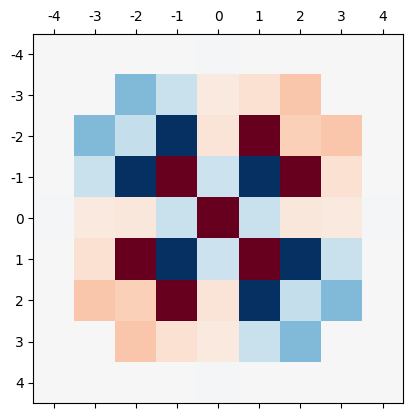

In [74]:



t3 = 0.75
mu = -2.60
U = 9.00
ff =4
delta = 0.01 #eV


model_normal = f"1NNN_0p75_hrmuneg2.60.dat"
SCgap_file = f"gap_file_t{t3}_mu{mu}_U{U}_ff{ff}.txt"
model_SCgap = f"1NN_t{t3}_mu{mu}_U{U}_SC.dat"



tb = tbModifer(model_normal,hasSOC=False)
tb.DefineAtomicInfo([Atom(name="Ru",position=[0,0,0],orbital_character=[1],hamiltonian_indices=[1],orientation = [1,0,0],SOC_LdotS_D=0.0)])
    #tb.add_SOC()#define the SOC parameters in the atom class. 
    #tb.set_FermiEnergy(0.0)
    #tb.add_Ferromagnetism(1.0)
    #tb.add_AntiFerromagnetism(1.0)
    #tb.add_SCgap_from_FRG("gap_file.txt")
    #tb.make_Nambau()
    #tb.plot_gap_file("gap_file_32_4_1.01.txt")
tb.plot_gap_file(SCgap_file)
tb.add_SCgap_from_FRG(SCgap_file,delta=float(delta))
tb.writeHamiltoniantoFile(model_SCgap,header=f"U = {U} eV, t3 = {t3} eV, mu = {mu} eV, ff = {ff} eV delta = {delta} eV")
plt.show()
   



Load_Kpoints_BZ took:  0.0009391307830810547 s
Load_Hamiltonian_grid took:  0.3936779499053955 s


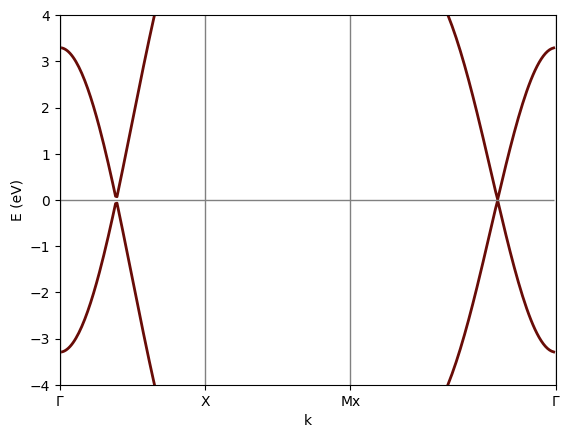

Load_Hamiltonian_grid_NormalState took:  0.8077466487884521 s
kz_index:0.0 (index 0)
average gap: 0.0003494662105022675
min_gap: -0.00524448250769061
max_gap: 0.004960828241519655


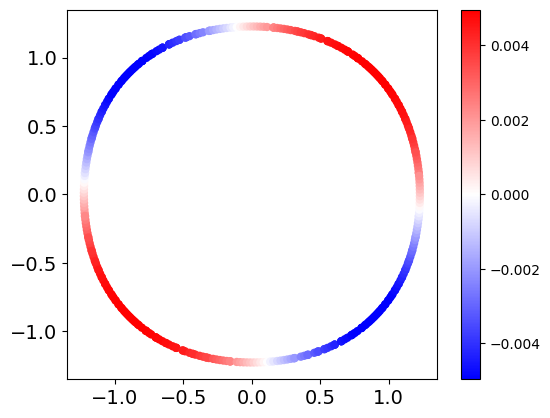

In [75]:
import Hamiltonian

model_normal = f"1NNN_0p75_hrmuneg2.60.dat"
SCgap_file = f"gap_file_t{t3}_mu{mu}_U{U}_ff{ff}.txt"
model_SCgap = f"1NN_t{t3}_mu{mu}_U{U}_SC.dat"



Ham = Hamiltonian.tbHamiltonian(model_SCgap,FermiEnergy = 0.0,no_kgrid=True,superconducting=True)

Ham.DefineOrbitals(["z2"],["purple"]) #DEFINE ORBITALS HERE
Ham.Load_kgrid(256,256,1)    



Hamplot = Hamiltonian.tbHamiltonian_Plot(Ham)

Gamma = [0.0,0.0,0.0] #in units of 2pi*b1,2pi*b2, 2pi*b3 where b1,b2,b3 are the reciprocal lattice vectors.
Y = [0.0,0.5,0.0]
X = [0.5,0.0,0.0] #for a square lattice with a=b=c=1 this would be the (pi,pi) point. 
M = [0.5,0.5,0]
Mp =[-0.5, 0.5,0.0]
Z = [0.0,0.0,0.5]
R = [0.5,0.0,0.5]
A = [0.5,0.5,0.5]
kpath = [Gamma,X,M,Gamma] #input your path as an array. I find it cleanest to write it like this
klabels = [r"$\Gamma$","X","Mx",r"$\Gamma$"] #Write your labels as well. 
Ymin = -4
Ymax = 4
bands_x,bands_y = Hamplot.BandStructure(kpath=kpath,klabels=klabels,YMIN=Ymin,YMAX=Ymax,linewidth=2,nk=99,Use_KPath_Distance=True)
plt.show()

 
Hamplot.plotGapAtEF(N_BrillouinZone=1)
plt.savefig(f"SC_gap_FS_{U}_{mu}.png")
plt.tick_params(axis='both', labelsize=14) 
plt.show()
   